In [236]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader

In [237]:
df = pd.read_csv('0050.TW.csv', index_col=0)
df2=pd.read_csv('2330.TW.csv', index_col=0)
df = df.round(3)
df2 = df2.round(3)
df = df.merge(df2[['Volume']], left_index=True, right_index=True, suffixes=('', '_2330'))
df.tail()

,Open,High,Low,Close,Adj Close,Volume,Volume_2330
Date,,,,,,,
2024-03-18,153.00,154.50,153.00,154.40,154.40,17937768,43589856
2024-03-19,153.40,154.55,153.00,154.05,154.05,8569789,30152375
2024-03-20,154.20,155.30,153.00,153.20,153.20,10080404,41280325
2024-03-21,155.55,157.70,155.55,157.40,157.40,19960806,46026103
2024-03-22,157.50,158.25,156.50,157.20,157.20,7137094,30660820


In [238]:
df.index = list(map(lambda x:datetime.datetime.strptime(x, '%Y-%m-%d'), df.index))
df.head()

,Open,High,Low,Close,Adj Close,Volume,Volume_2330
2023-03-23,120.65,122.30,120.45,121.85,117.359,15532979,26728246
2023-03-24,122.00,122.30,121.55,122.20,117.696,13457394,21926240
2023-03-27,121.75,121.90,121.20,121.45,116.974,10644595,16111177
2023-03-28,120.95,121.15,120.20,120.40,115.963,9741489,17234120
2023-03-29,120.65,121.05,120.15,120.60,116.155,3074427,17280749


# FUNTION Def

In [239]:
def getData(df, feature_columns, label_column, train_end=-30, days_before=30, standardize=True):
    series = df.copy()
    mean = series.mean()
    std = series.std()
    if standardize:
        series = (series - mean)/std

    # 划分数据
    # 0 ~ train_end 的为训练数据，但实际上，最后的 n 天只是作为 label
    # 而 train 中的 label，可用于 test
    train_series = series[feature_columns][:train_end]
    # 创建训练集
    train_feature = pd.DataFrame()
    train_label = pd.DataFrame()

    # 通过移位，创建历史 days_before 天的数据
    for i in range(days_before):
    # 当前数据的 7 天前的数据，应该取 开始到 7 天前的数据； 昨天的数据，应该为开始到昨天的数据，如：
    # [..., 1,2,3,4,5,6,7] 昨天的为 [..., 1,2,3,4,5,6]
    # 比如从 [2:-7+2]，其长度为 len - 7
        train_feature['bday%d' % i] = train_series[i: -days_before + i].values.tolist()

    # 获取对应的 label
    train_label['y'] = series[label_column].to_numpy()[days_before:]
    #print(train_data["bday4"])
    return train_feature, train_label, df.index.tolist()

In [240]:
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()

        self.lstm = nn.LSTM(
          input_size=len(FEATURES),
          hidden_size=64,
          num_layers=2,
          batch_first=True)

        self.linear = nn.Linear(64,1)

    def predict(self, input):
        with torch.no_grad():
            return self.forward(input)

    def forward(self, x):
        r_out, (h_n, c_n) = self.lstm(x, None)  # None 表示 hidden state 会用全 0 的 state
        out = self.linear(r_out)     # 取最后一天作为输出
        return out, (h_n,c_n)

In [241]:
class TrainSet(Dataset):
    def __init__(self, x, y):
        # data 取前多少天的数据， label 取最后一天的数据
        self.data, self.label = x[:, :-1].float(), y[:, -1].float()

    def __getitem__(self, index):
        return self.data[index], self.label[index]

    def __len__(self):
        return len(self.data)

In [242]:
#Make test set for testing
def getTestData(df, feature_columns, label_column, train_end=-30, days_before=30, standardize=True):
    series = df.copy()
    mean = series.mean()
    std = series.std()
    if standardize:
        series = (series - mean)/std

    # 划分数据
    # 0 ~ train_end 的为训练数据，但实际上，最后的 n 天只是作为 label
    # 而 train 中的 label，可用于 test
    test_series = series[feature_columns][train_end-days_before:]
    # 创建训练集
    test_feature = pd.DataFrame()
    test_label = pd.DataFrame()

    # 通过移位，创建历史 days_before 天的数据
    for i in range(days_before):
        # 当前数据的 7 天前的数据，应该取 开始到 7 天前的数据； 昨天的数据，应该为开始到昨天的数据，如：
        # [..., 1,2,3,4,5,6,7] 昨天的为 [..., 1,2,3,4,5,6]
        # 比如从 [2:-7+2]，其长度为 len - 7

        test_feature['bday%d' % i] = test_series[i: -days_before + i].values.tolist()

    # 获取对应的 label
    test_label['y'] = series[label_column].to_numpy()[days_before:]
    #print(train_data["bday4"])
    return test_feature, test_label, df.index.tolist()

# ALL FEATURE

In [243]:
LR = 0.0001
EPOCH = 1000
BATCH_SIZE = 200
TRAIN_END=-1
DAYS_BEFORE=7
FEATURES = [ "Open", "High", "Low",	"Close", "Adj Close", "Volume","Volume_2330"]
feature_index = {feature: index for index, feature in enumerate(FEATURES)}
rnns = {feature: LSTM() for feature in FEATURES}

# Open

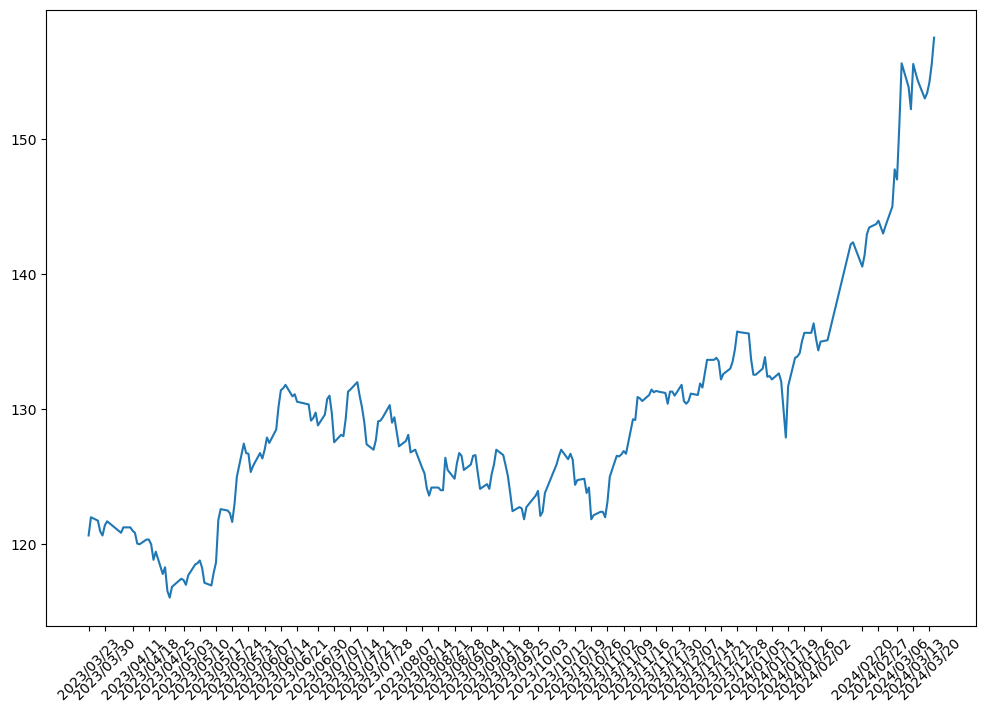

In [244]:
LABEL =  "Open"

# 数据集建立
train_feature, train_label, df_index= getData(df, FEATURES, LABEL, days_before=DAYS_BEFORE, train_end=TRAIN_END)
#print(train_feature)
# 获取所有原始数据
all_series = np.array(df[LABEL].tolist())
# 绘制原始数据的图
plt.figure(figsize=(12,8))
plt.plot(df_index, all_series, label='real-data')
# 设置 X 轴的刻度
plt.xticks(df_index[::5], pd.to_datetime(df_index[::5]).strftime('%Y/%m/%d'),rotation=45)
# 隐藏 X 轴的次刻度
plt.minorticks_off()
plt.show()

# flatern each day in train data
train_feature_tensor = torch.Tensor(np.array(train_feature.values.tolist()))
train_label_tensor = torch.Tensor(np.array(train_label.values.tolist()))
# 创建 dataloader
# print(train_feature_tensor)
# print(train_label_tensor)
train_set = TrainSet(train_feature_tensor, train_label_tensor)
# print(train_set.__len__())
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)


0 0.0036444082856178285
1 0.007553487420082093
2 0.004553260207176208
3 0.00427714079618454
4 0.005761397480964661
5 0.008391395807266236
6 0.003943443298339844
7 0.00596616268157959
8 0.004980839192867279
9 0.003453608751296997
10 0.004096732437610626
11 0.005582857131958008
12 0.003436248302459717
13 0.003867378234863281
14 0.004953116774559021
15 0.005074459910392761
16 0.006445868611335754
17 0.005224821567535401
18 0.0034440502524375914
19 0.005005555748939514
20 0.007063193321228027
21 0.003539406955242157
22 0.006854085922241211
23 0.0061262154579162596
24 0.0031020846962928773
25 0.004488669335842133
26 0.0036541587114334107
27 0.00380376935005188
28 0.0037595784664154054
29 0.004675969779491425
30 0.0026118370890617373
31 0.002848556935787201
32 0.0035116547346115113
33 0.0032240155339241026
34 0.004806749522686005
35 0.0030714595317840577
36 0.004149458706378937
37 0.003214755654335022
38 0.003339218497276306
39 0.002559014856815338
40 0.0033487045764923097
41 0.0038256406784

318 0.00026046503335237504
319 0.00031203875318169594
320 0.000255450326949358
321 0.00021221162751317024
322 0.00022164177149534226
323 0.00022673306986689567
324 0.00019368266686797141
325 0.00024376163259148598
326 0.00014982691965997218
327 0.000265236534178257
328 0.00027264315634965895
329 0.00015396441332995891
330 0.000251129362732172
331 0.0001561737898737192
332 0.00026890531182289124
333 0.0002453966066241264
334 0.00017005357891321184
335 0.00023121923208236695
336 0.0001680479757487774
337 0.00017217915505170821
338 0.00027695680037140844
339 0.0002945893071591854
340 0.0001878052204847336
341 0.00033236991614103316
342 0.0002624644339084625
343 0.00023347469046711922
344 0.00017145050689578055
345 0.00021906429901719093
346 0.00029251037165522575
347 0.00020454656332731248
348 0.00021996038034558297
349 0.0002732831984758377
350 0.0002265733852982521
351 0.0001920328103005886
352 0.00025038497522473336
353 0.00017871323972940445
354 0.00022236593067646027
355 0.0002005868

627 0.0001038147509098053
628 0.00017096806317567825
629 0.00037210624665021894
630 0.00019853157922625542
631 0.0001970633864402771
632 0.00020143697038292884
633 0.0003042546659708023
634 0.00022475212812423707
635 0.00019195225089788437
636 0.00017451060935854911
637 0.00021509047597646715
638 0.0002153225615620613
639 0.00022593129426240921
640 0.00022834260016679764
641 0.00015962690114974974
642 0.0002350149117410183
643 0.00029821038246154787
644 0.00028100399300456046
645 0.00015837647020816803
646 0.0001586124300956726
647 0.0002154708094894886
648 0.00021263619884848595
649 0.0002817681804299355
650 0.0002433362789452076
651 0.00021716078743338584
652 0.00011722977273166179
653 0.00020394066348671913
654 0.00018547672778367996
655 0.00013186078518629074
656 0.00014913232065737246
657 0.0001911860890686512
658 0.00021436071023344993
659 0.0002336348406970501
660 0.0002146110124886036
661 0.00016360562294721604
662 0.00019071977585554122
663 0.00016097793355584144
664 0.0001823

935 0.00013700607232749462
936 0.00022383011877536775
937 0.00018659530207514762
938 0.00018139900639653207
939 0.0001394673902541399
940 0.00011927533894777298
941 0.0002409506216645241
942 0.00016150515526533127
943 0.00018478838726878165
944 0.00015038445591926574
945 0.00032245941460132596
946 0.00011643704026937485
947 0.00016231438145041465
948 0.0002055402472615242
949 0.00016135554760694505
950 0.00022484758868813516
951 0.0001405742671340704
952 0.00019083911553025246
953 0.00018644828349351884
954 0.000155731113627553
955 0.0002608697861433029
956 0.00013103016652166844
957 0.00016171861439943314
958 0.00020353347063064575
959 0.00015015386044979096
960 0.00024212505668401717
961 0.00019294168800115585
962 0.00023829642683267593
963 0.00025128327310085295
964 0.00017355689778923987
965 0.00014556488022208214
966 0.000142366923391819
967 0.00012616083025932312
968 9.549841284751892e-05
969 0.00014069762080907823
970 0.0001672322116792202
971 0.0002606389299035072
972 0.0001185

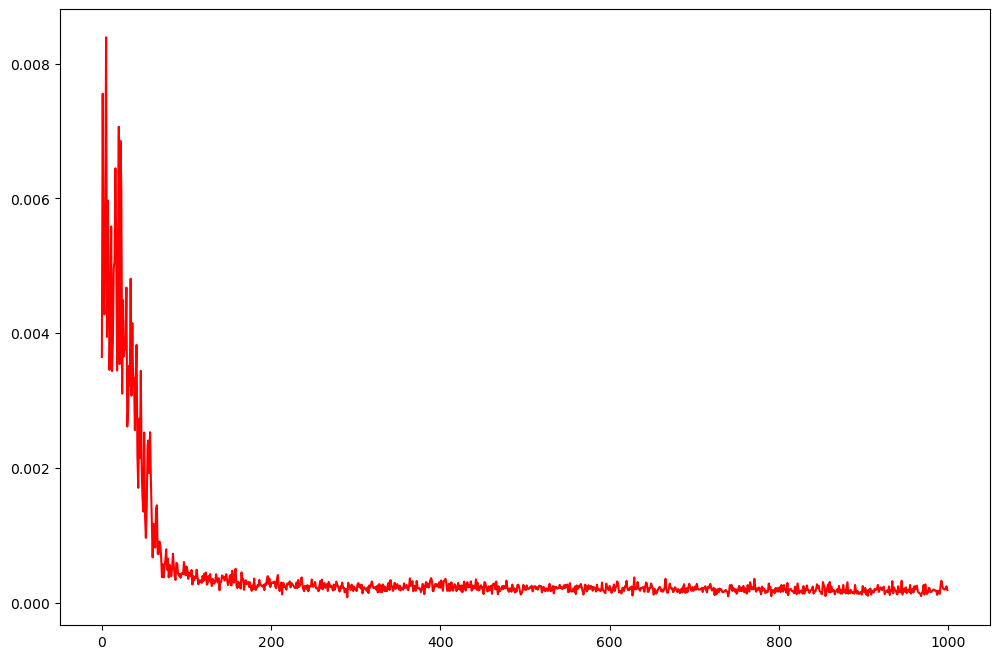

In [245]:
#訓練
# rnn = torch.load('rnn.pkl')

losses = []


optimizer = torch.optim.Adam(rnns[LABEL].parameters(), lr=LR) # optimize all cnn parameters
loss_func = nn.MSELoss()
for step in range(EPOCH):
    for tx, ty in train_loader:
        optimizer.zero_grad() # clear gradients for this training step
        # print(tx.shape)
        # print(tx)
        output,(h_n,c_n) = rnns[LABEL](tx)
        ty=torch.squeeze(ty)
        # print(ty.shape)
        # print(torch.squeeze(output[:,-1,:]).shape)
        loss = loss_func(torch.squeeze(output[:,-1,:]), ty)
        # print(loss)

        loss.backward() # back propagation, compute gradients
        optimizer.step()
    losses.append(loss.item()/BATCH_SIZE)
    print(step, losses[-1])
    if step % 10:
        torch.save(rnns[LABEL], f'rnn_{LABEL}mul+2330.pt')
torch.save(rnns[LABEL], f'rnn_{LABEL}mul+2330.pt')
plt.figure(figsize=(12,8))
plt.plot(np.array(losses), 'r')
plt.show()

In [246]:
test_feature, test_label, df_index= getTestData(df, FEATURES, LABEL, days_before=DAYS_BEFORE, train_end=TRAIN_END)
# flatern each day in train data
test_feature_tensor = torch.Tensor(np.array(test_feature.values.tolist()))
test_label_tensor = torch.Tensor(np.array(test_label.values.tolist()))
# 创建 dataloader
# print(train_feature_tensor)
# print(train_label_tensor)
test_set = TrainSet(test_feature_tensor, test_label_tensor)
# print(train_set.__len__())
train_test_loader = DataLoader(train_set, batch_size=1, shuffle=False)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)

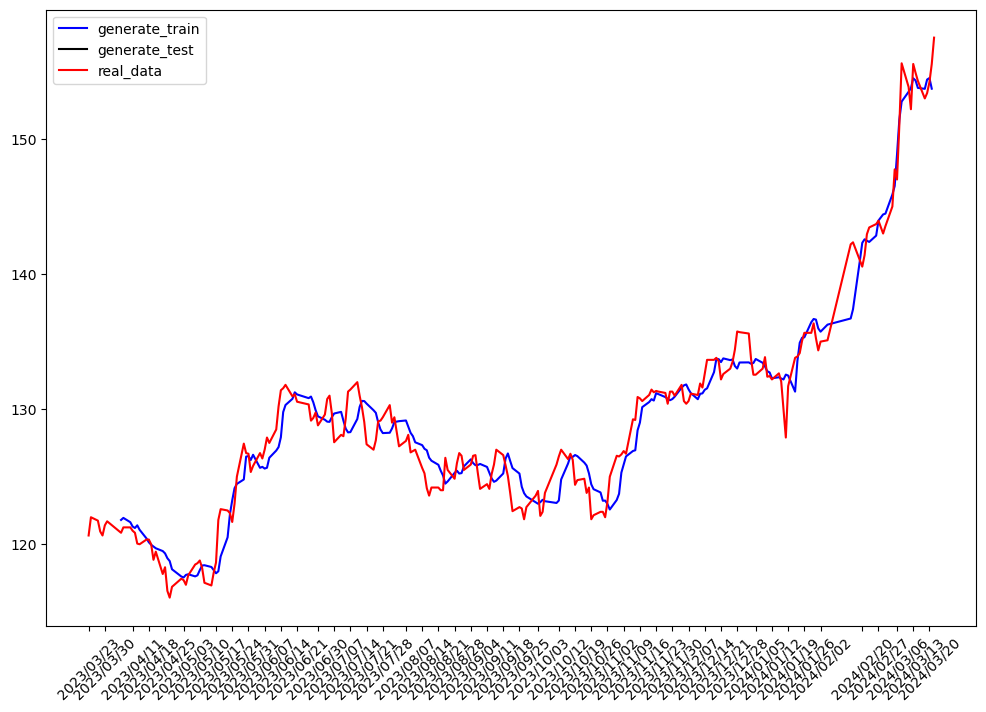

In [247]:
generate_data_train = []
generate_data_test = []
# 测试数据开始的索引
test_start = len(all_series) + TRAIN_END
# 对所有的数据进行相同的归一化
train_mean = all_series.mean()
train_std = all_series.std()
all_series_std = (all_series - train_mean) / train_std
all_series_std = torch.Tensor(all_series_std)
for tx, ty in train_test_loader:
    out, (h_n,c_n) = rnns[LABEL].predict(tx)
#     print(out.detach().flatten()[-1])
    generate_data_train.append(out.detach().flatten()[-1] * train_std + train_mean)
for tx, ty in test_loader:
    out, (h_n,c_n) = rnns[LABEL].predict(tx)
    generate_data_test.append(out.detach().flatten()[-1] * train_std + train_mean)

plt.figure(figsize=(12,8))
plt.plot(df_index[DAYS_BEFORE: TRAIN_END], generate_data_train, 'b', label='generate_train', )
plt.plot(df_index[TRAIN_END:], generate_data_test, 'k', label='generate_test')
plt.plot(df_index, all_series_std.clone().numpy()* train_std + train_mean, 'r', label='real_data')
# 设置 X 轴的刻度
plt.xticks(df_index[::5], pd.to_datetime(df_index[::5]).strftime('%Y/%m/%d'),rotation=45)
# 隐藏 X 轴的次刻度
# plt.minorticks_off()
plt.legend()
plt.show()


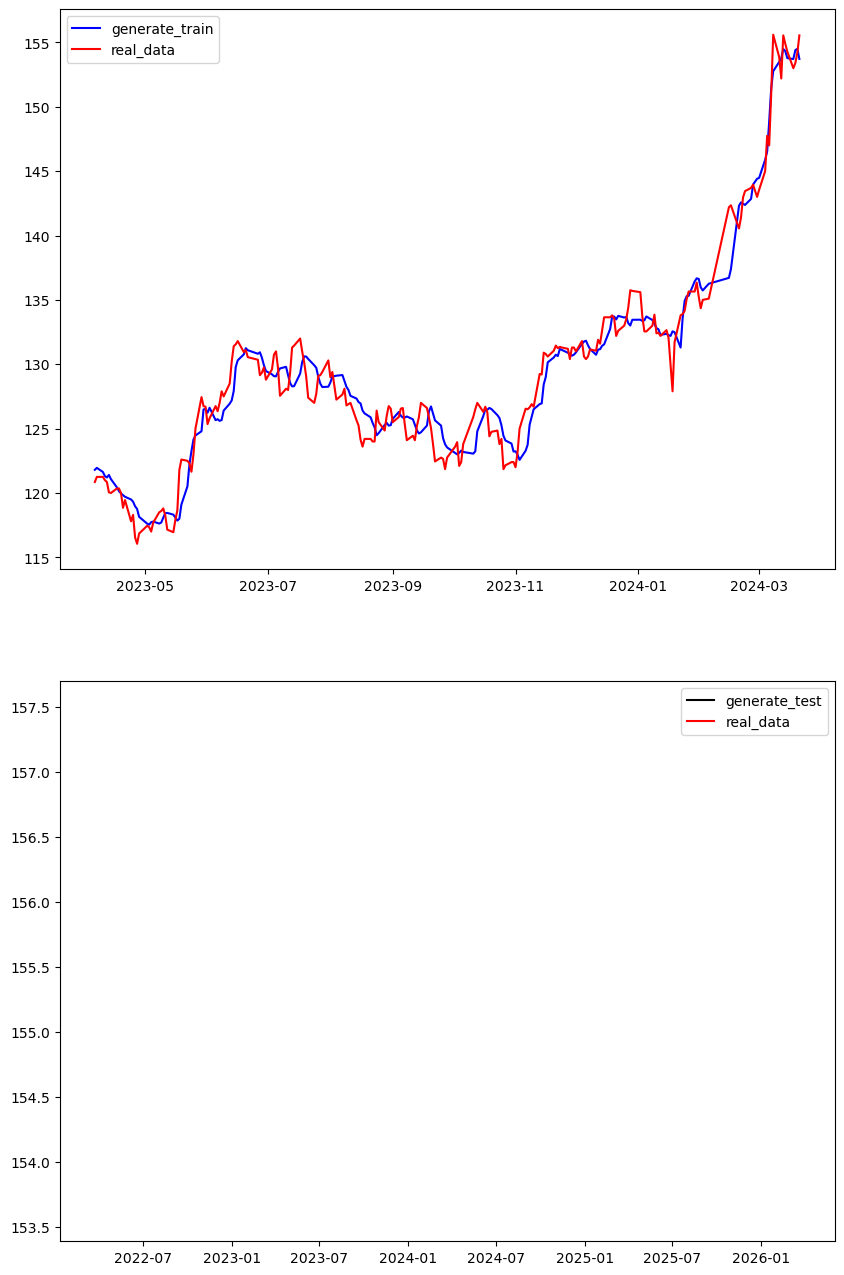

In [248]:
plt.figure(figsize=(10,16))

plt.subplot(2,1,1)
# plt.plot(df_index[100 + DAYS_BEFORE: 130 + DAYS_BEFORE], generate_data_train[100: 130], 'b', label='generate_train')
plt.plot(df_index[7: TRAIN_END], generate_data_train[:], 'b', label='generate_train')
# plt.plot(df_index[100 + DAYS_BEFORE: 130 + DAYS_BEFORE], (all_series.clone().numpy()* train_std + train_mean)[100 + DAYS_BEFORE: 130 + DAYS_BEFORE], 'r', label='real_data')
plt.plot(df_index[7:TRAIN_END], (all_series_std.clone().numpy()* train_std + train_mean)[7: TRAIN_END], 'r', label='real_data')
plt.legend()

plt.subplot(2,1,2)
plt.plot(df_index[TRAIN_END :], generate_data_test[:], 'k', label='generate_test')
plt.plot(df_index[TRAIN_END:], (all_series_std.clone().numpy()* train_std + train_mean)[TRAIN_END :], 'r', label='real_data')
plt.legend()

plt.show()

# High

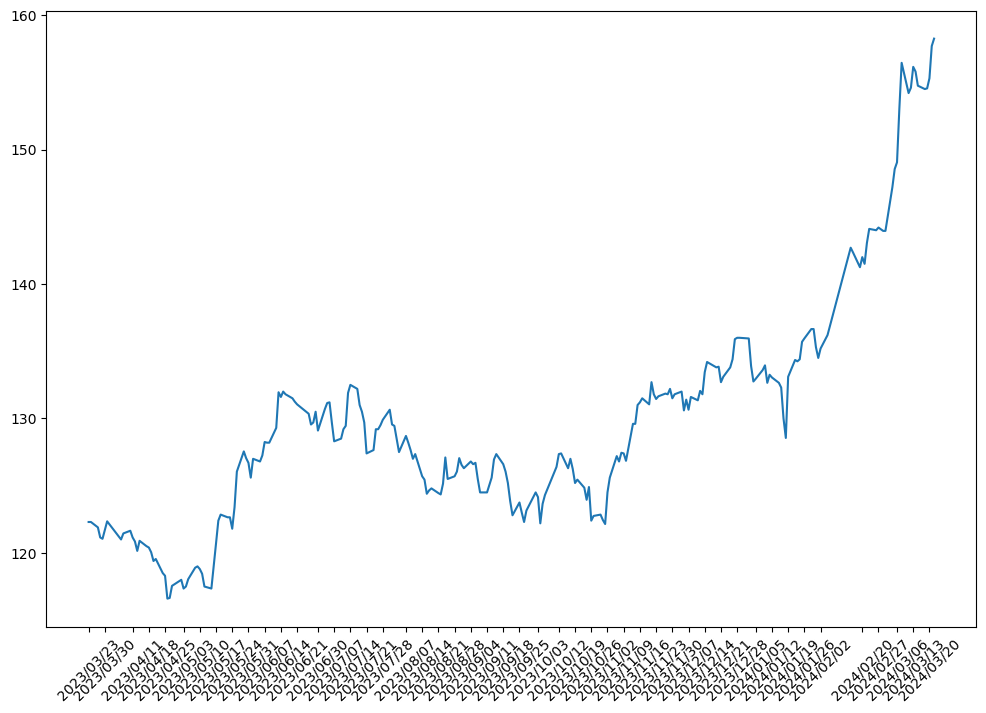

In [249]:
LABEL =  "High"

# 数据集建立
train_feature, train_label, df_index= getData(df, FEATURES, LABEL, days_before=DAYS_BEFORE, train_end=TRAIN_END)
#print(train_feature)
# 获取所有原始数据
all_series = np.array(df[LABEL].tolist())
# 绘制原始数据的图
plt.figure(figsize=(12,8))
plt.plot(df_index, all_series, label='real-data')
# 设置 X 轴的刻度
plt.xticks(df_index[::5], pd.to_datetime(df_index[::5]).strftime('%Y/%m/%d'),rotation=45)
# 隐藏 X 轴的次刻度
plt.minorticks_off()
plt.show()

# flatern each day in train data
train_feature_tensor = torch.Tensor(np.array(train_feature.values.tolist()))
train_label_tensor = torch.Tensor(np.array(train_label.values.tolist()))
# 创建 dataloader
# print(train_feature_tensor)
# print(train_label_tensor)
train_set = TrainSet(train_feature_tensor, train_label_tensor)
# print(train_set.__len__())
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)


0 0.004986625015735626
1 0.0058913004398345944
2 0.006538588404655456
3 0.0032449591159820555
4 0.0035124659538269044
5 0.0036299821734428407
6 0.005835629105567932
7 0.004221091568470001
8 0.005660630464553833
9 0.004121094048023224
10 0.0036780792474746704
11 0.005562739372253418
12 0.0023580221831798554
13 0.002637368142604828
14 0.002186737507581711
15 0.006978285908699036
16 0.005399702787399292
17 0.0026229605078697204
18 0.006596208214759826
19 0.0029020363092422483
20 0.0065218120813369754
21 0.0047756308317184444
22 0.0014025457203388214
23 0.004525915086269379
24 0.0062057900428771975
25 0.0036746421456336975
26 0.00301079124212265
27 0.0037884458899497984
28 0.006007187366485596
29 0.003236963450908661
30 0.004369101524353027
31 0.0030766117572784426
32 0.006315764784812927
33 0.004460228681564331
34 0.004125709235668182
35 0.0026384943723678587
36 0.0034753885865211488
37 0.002840774655342102
38 0.003691821098327637
39 0.0035492345690727235
40 0.004206219911575318
41 0.0025

318 0.00020309250801801683
319 0.0003097313456237316
320 0.0003225424885749817
321 0.00024095088243484498
322 0.0002091233991086483
323 0.0002298230677843094
324 0.00018852854147553445
325 0.00014865525998175144
326 0.0002532546408474445
327 0.00028278898447752
328 0.00021984288468956947
329 0.00027568519115447995
330 0.0003317238762974739
331 0.0002336960658431053
332 0.0002520470879971981
333 0.0002660495229065418
334 0.0002546873688697815
335 0.00022589072585105897
336 0.00018882423639297486
337 0.000253527108579874
338 0.00025176690891385076
339 0.0001831495575606823
340 0.0001675393059849739
341 0.000274419691413641
342 0.0001493348740041256
343 0.00016152936965227127
344 0.00018904486671090126
345 0.00040182620286941526
346 0.00017565561458468437
347 0.0002075398899614811
348 0.0002100099064409733
349 0.00023561567068099975
350 0.00016474645584821701
351 0.0002474660612642765
352 0.0003099953196942806
353 0.00026137232780456545
354 0.0002845048904418945
355 0.0002665954269468784


627 0.00020436249673366546
628 0.0002309606783092022
629 0.00027984529733657835
630 0.00023387283086776734
631 0.0001761283539235592
632 0.0002016335166990757
633 0.00012300703674554824
634 0.00020308773964643477
635 0.00021122755482792853
636 0.00020508619025349617
637 0.00019561760127544402
638 0.0002125811390578747
639 0.00013885680586099623
640 0.00022083960473537445
641 0.0001780325174331665
642 0.000143796494230628
643 0.0002362935058772564
644 0.0002816169895231724
645 0.00027645202353596685
646 0.00012923228554427622
647 0.0002810676023364067
648 0.0002191382087767124
649 0.00017605382949113845
650 0.0001437307056039572
651 0.00023014910519123078
652 0.00017178066074848174
653 0.00024279482662677764
654 0.00020780447870492934
655 0.00025571394711732865
656 0.00024108778685331345
657 0.00020231612026691437
658 0.00016403345391154288
659 0.00020449306815862657
660 0.00014657209627330303
661 0.00020339822396636009
662 0.0001122977863997221
663 0.00022539876401424407
664 0.00018045

935 0.00020961163565516472
936 0.00015187524259090422
937 0.00013974512927234173
938 0.00014719601720571517
939 0.000212883111089468
940 0.0002689625509083271
941 0.00017423605546355248
942 0.00015149884857237338
943 0.00011580794118344784
944 0.00019324991852045058
945 0.00013825817964971065
946 0.0001949816755950451
947 0.000277421809732914
948 9.928538464009761e-05
949 0.000184651967138052
950 0.0002317243628203869
951 0.00015293405391275883
952 0.00020799711346626283
953 0.00020848557353019714
954 0.00016495700925588607
955 0.00025305155664682386
956 0.00016701806336641312
957 0.00018199412152171136
958 0.00014859373681247234
959 0.0001519875880330801
960 0.00017188573256134986
961 0.00022839395329356195
962 0.00013448686338961126
963 0.0001978546567261219
964 0.00015377487055957318
965 0.00020554594695568085
966 0.00015663104131817817
967 0.00014758403412997722
968 0.00013486837968230248
969 0.00023019349202513695
970 0.000139832841232419
971 0.00022743241861462594
972 0.000259294

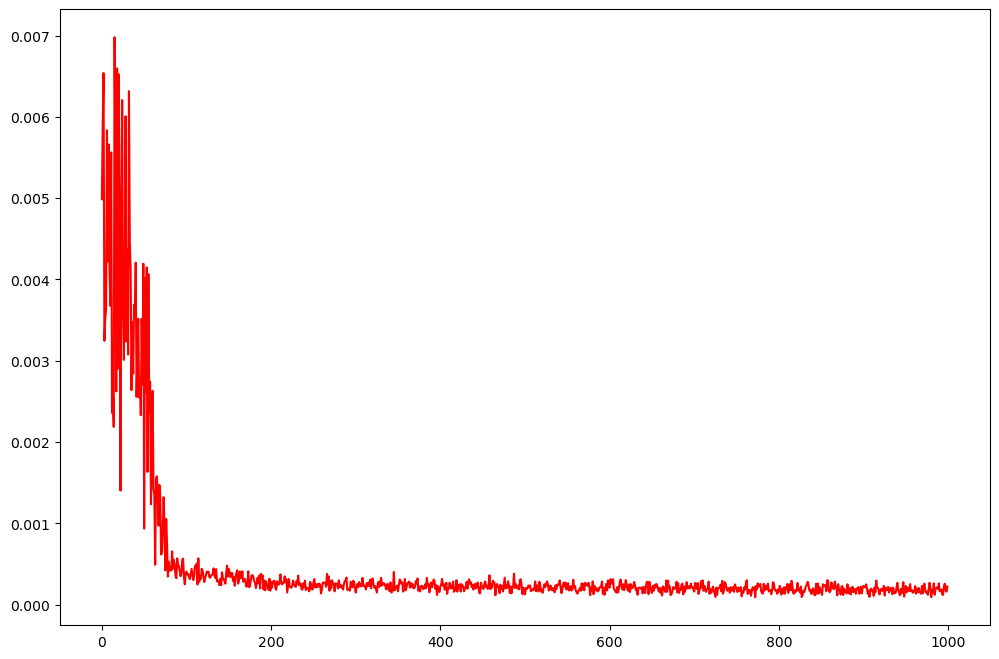

In [250]:
#訓練
# rnn = torch.load('rnn.pkl')

losses = []


optimizer = torch.optim.Adam(rnns[LABEL].parameters(), lr=LR) # optimize all cnn parameters
loss_func = nn.MSELoss()
for step in range(EPOCH):
    for tx, ty in train_loader:
        optimizer.zero_grad() # clear gradients for this training step
        # print(tx.shape)
        # print(tx)
        output,(h_n,c_n) = rnns[LABEL](tx)
        ty=torch.squeeze(ty)
        # print(ty.shape)
        # print(torch.squeeze(output[:,-1,:]).shape)
        loss = loss_func(torch.squeeze(output[:,-1,:]), ty)
        # print(loss)

        loss.backward() # back propagation, compute gradients
        optimizer.step()
    losses.append(loss.item()/BATCH_SIZE)
    print(step, losses[-1])
    if step % 10:
        torch.save(rnns[LABEL], f'rnn_{LABEL}mul+2330.pt')
torch.save(rnns[LABEL], f'rnn_{LABEL}mul+2330.pt')
plt.figure(figsize=(12,8))
plt.plot(np.array(losses), 'r')
plt.show()

In [251]:
test_feature, test_label, df_index= getTestData(df, FEATURES, LABEL, days_before=DAYS_BEFORE, train_end=TRAIN_END)
# flatern each day in train data
test_feature_tensor = torch.Tensor(np.array(test_feature.values.tolist()))
test_label_tensor = torch.Tensor(np.array(test_label.values.tolist()))
# 创建 dataloader
# print(train_feature_tensor)
# print(train_label_tensor)
test_set = TrainSet(test_feature_tensor, test_label_tensor)
# print(train_set.__len__())
train_test_loader = DataLoader(train_set, batch_size=1, shuffle=False)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)

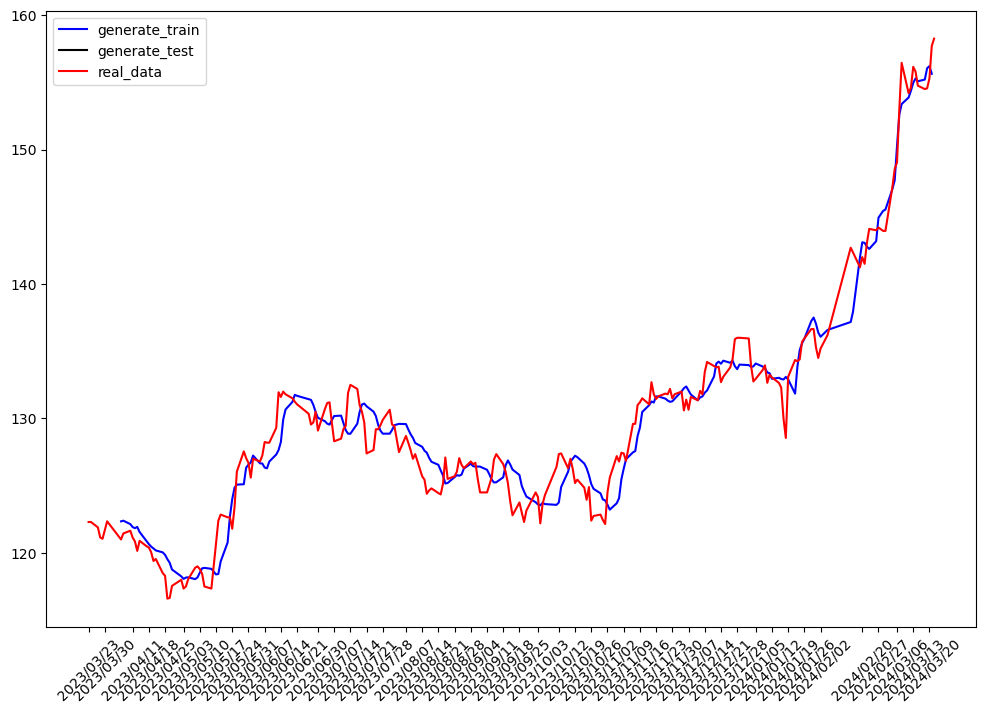

In [252]:
generate_data_train = []
generate_data_test = []
# 测试数据开始的索引
test_start = len(all_series) + TRAIN_END
# 对所有的数据进行相同的归一化
train_mean = all_series.mean()
train_std = all_series.std()
all_series_std = (all_series - train_mean) / train_std
all_series_std = torch.Tensor(all_series_std)
for tx, ty in train_test_loader:
    out, (h_n,c_n) = rnns[LABEL].predict(tx)
#     print(out.detach().flatten()[-1])
    generate_data_train.append(out.detach().flatten()[-1] * train_std + train_mean)
for tx, ty in test_loader:
    out, (h_n,c_n) = rnns[LABEL].predict(tx)
    generate_data_test.append(out.detach().flatten()[-1] * train_std + train_mean)

plt.figure(figsize=(12,8))
plt.plot(df_index[DAYS_BEFORE: TRAIN_END], generate_data_train, 'b', label='generate_train', )
plt.plot(df_index[TRAIN_END:], generate_data_test, 'k', label='generate_test')
plt.plot(df_index, all_series_std.clone().numpy()* train_std + train_mean, 'r', label='real_data')
# 设置 X 轴的刻度
plt.xticks(df_index[::5], pd.to_datetime(df_index[::5]).strftime('%Y/%m/%d'),rotation=45)
# 隐藏 X 轴的次刻度
# plt.minorticks_off()
plt.legend()
plt.show()


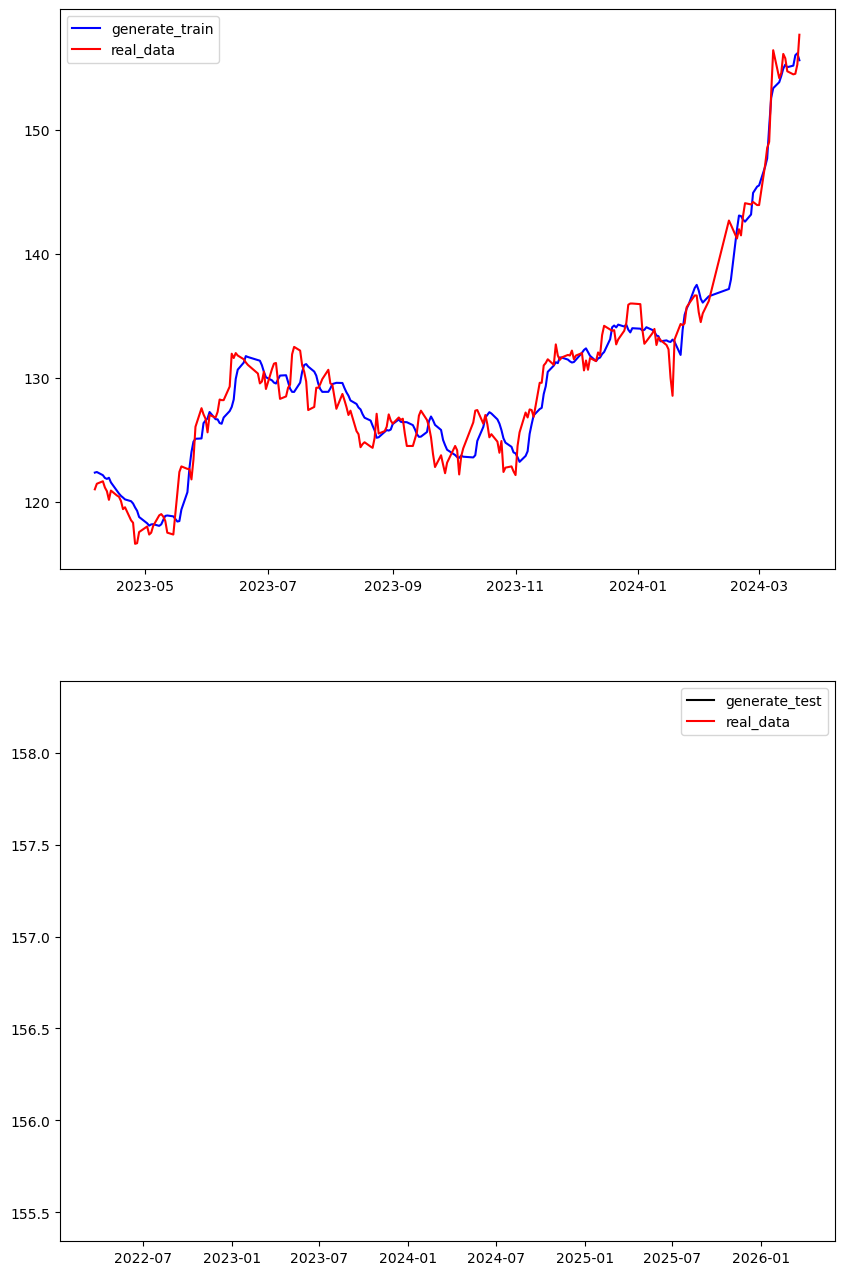

In [253]:
plt.figure(figsize=(10,16))

plt.subplot(2,1,1)
# plt.plot(df_index[100 + DAYS_BEFORE: 130 + DAYS_BEFORE], generate_data_train[100: 130], 'b', label='generate_train')
plt.plot(df_index[7: TRAIN_END], generate_data_train[:], 'b', label='generate_train')
# plt.plot(df_index[100 + DAYS_BEFORE: 130 + DAYS_BEFORE], (all_series.clone().numpy()* train_std + train_mean)[100 + DAYS_BEFORE: 130 + DAYS_BEFORE], 'r', label='real_data')
plt.plot(df_index[7:TRAIN_END], (all_series_std.clone().numpy()* train_std + train_mean)[7: TRAIN_END], 'r', label='real_data')
plt.legend()

plt.subplot(2,1,2)
plt.plot(df_index[TRAIN_END :], generate_data_test[:], 'k', label='generate_test')
plt.plot(df_index[TRAIN_END:], (all_series_std.clone().numpy()* train_std + train_mean)[TRAIN_END :], 'r', label='real_data')
plt.legend()

plt.show()

# Low

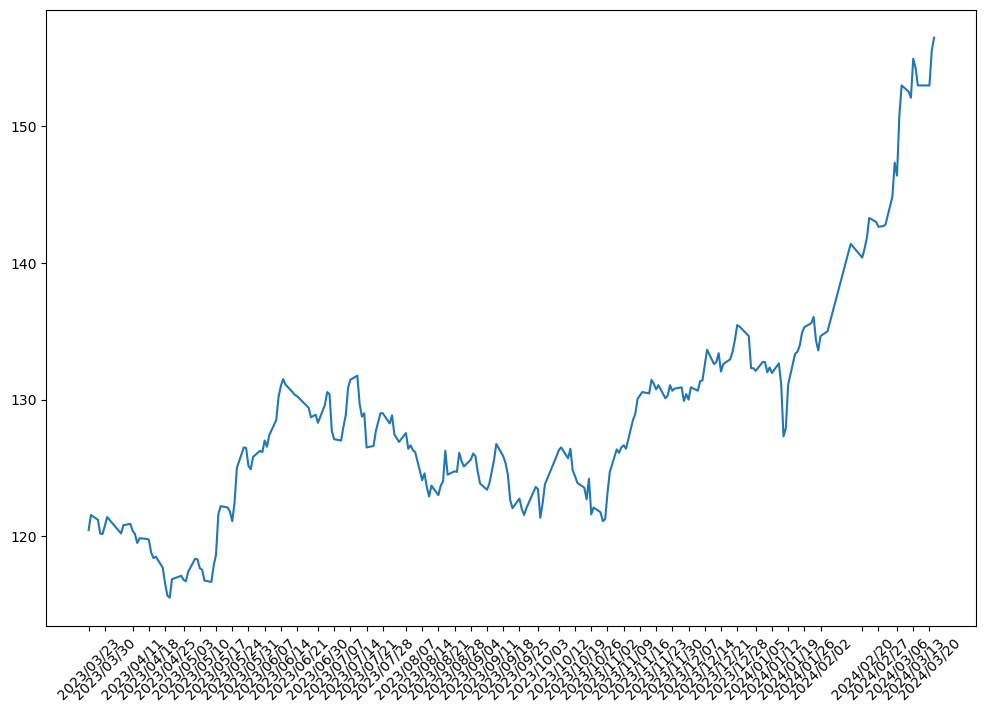

In [254]:
LABEL =  "Low"

# 数据集建立
train_feature, train_label, df_index= getData(df, FEATURES, LABEL, days_before=DAYS_BEFORE, train_end=TRAIN_END)
#print(train_feature)
# 获取所有原始数据
all_series = np.array(df[LABEL].tolist())
# 绘制原始数据的图
plt.figure(figsize=(12,8))
plt.plot(df_index, all_series, label='real-data')
# 设置 X 轴的刻度
plt.xticks(df_index[::5], pd.to_datetime(df_index[::5]).strftime('%Y/%m/%d'),rotation=45)
# 隐藏 X 轴的次刻度
plt.minorticks_off()
plt.show()

# flatern each day in train data
train_feature_tensor = torch.Tensor(np.array(train_feature.values.tolist()))
train_label_tensor = torch.Tensor(np.array(train_label.values.tolist()))
# 创建 dataloader
# print(train_feature_tensor)
# print(train_label_tensor)
train_set = TrainSet(train_feature_tensor, train_label_tensor)
# print(train_set.__len__())
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)


0 0.0045527186989784245
1 0.006401550769805908
2 0.005642261505126953
3 0.004581865072250366
4 0.003761172592639923
5 0.006010199785232544
6 0.004131820797920227
7 0.004479279518127441
8 0.00392031192779541
9 0.005528151392936707
10 0.004189262986183166
11 0.003273531496524811
12 0.003320699334144592
13 0.00536439836025238
14 0.005395359396934509
15 0.006444158554077148
16 0.0047203353047370914
17 0.0045897701382637025
18 0.005216180086135864
19 0.005814858675003052
20 0.004831270575523377
21 0.0032653218507766725
22 0.0023984596133232116
23 0.004194506108760833
24 0.0035092487931251528
25 0.00332309752702713
26 0.004291889667510987
27 0.004094153940677643
28 0.00733181357383728
29 0.004642630517482757
30 0.004696923494338989
31 0.005751520991325378
32 0.004437989592552185
33 0.006728794574737549
34 0.0032679104804992677
35 0.004099386632442474
36 0.0028849634528160095
37 0.0032966187596321105
38 0.0031499400734901427
39 0.0033907628059387206
40 0.004827637672424317
41 0.00335985004901

318 0.00036123469471931456
319 0.00023438181728124618
320 0.00024665744975209235
321 0.00030064163729548454
322 0.0002610323950648308
323 0.00020758816972374917
324 0.00020353438332676888
325 0.0002403418719768524
326 0.00023717468604445458
327 0.0002472018077969551
328 0.00016626056283712388
329 0.00018077315762639047
330 0.00024144286289811133
331 0.0003298595175147057
332 0.0003893508389592171
333 0.00026789920404553415
334 0.00024015765637159348
335 0.0002085307613015175
336 0.0001710553653538227
337 0.00019583851099014282
338 0.0002448635548353195
339 0.00021285435184836387
340 0.00021886864677071573
341 0.00018610114231705664
342 0.00026569217443466185
343 0.00020864423364400864
344 0.0003068027086555958
345 0.00030699774622917176
346 0.0002781553007662296
347 0.0002998408302664757
348 0.0002974330075085163
349 0.0002449437603354454
350 0.00020383169874548912
351 0.00012645448558032513
352 0.00022940145805478096
353 0.00020544763654470444
354 0.0001786930300295353
355 0.000197509

628 0.00016413241624832153
629 0.0002022458054125309
630 0.00039081159979104997
631 0.00020552188158035279
632 0.00016567917540669442
633 0.00020700566470623018
634 0.0001736435852944851
635 0.0003338680788874626
636 0.00028443373739719393
637 0.00017573986202478408
638 0.0002298112213611603
639 0.00021616077050566672
640 0.00019061557948589326
641 0.00012644484639167785
642 0.00016480568796396256
643 0.0002689296565949917
644 0.00024812361225485803
645 0.00017834611237049102
646 0.00032296739518642423
647 0.00022597569972276687
648 0.00013206822797656059
649 0.0001401979010552168
650 0.00018575048074126243
651 0.0002070526033639908
652 0.00025058688595891
653 0.00021266387775540352
654 0.0002634435333311558
655 0.00021939247846603394
656 0.0002525351569056511
657 0.00016423741355538367
658 0.000187501423060894
659 0.0002492991276085377
660 0.00022908465936779976
661 0.00020895257592201232
662 0.00027689162641763687
663 0.00023575043305754662
664 0.00023822715505957603
665 0.0001767018

936 0.00014515720307826995
937 0.00020165080204606056
938 0.0002785109728574753
939 0.0002415510267019272
940 0.00017776153981685638
941 0.00016971286386251449
942 0.00022869171574711798
943 0.00021755833178758622
944 0.00022741546854376793
945 0.0002354508638381958
946 0.00016597148030996322
947 0.0002082435041666031
948 0.0002574680931866169
949 0.0001709548570215702
950 0.00021564619615674019
951 0.00011464952491223813
952 0.00015451797284185887
953 0.0001796313561499119
954 0.00022360386326909066
955 0.00021443035453557968
956 0.0001442133728414774
957 0.00024072878062725067
958 0.00017775394022464752
959 0.00019827822223305702
960 0.00016323532909154893
961 0.0002009306661784649
962 0.00011426704935729503
963 0.00016094973310828208
964 0.00023870810866355896
965 0.00013250266201794147
966 0.000141280684620142
967 0.0001338755991309881
968 0.00019341610372066497
969 0.00017511524260044098
970 0.0001993137039244175
971 0.00021936921402812004
972 0.00014352823607623576
973 0.00025228

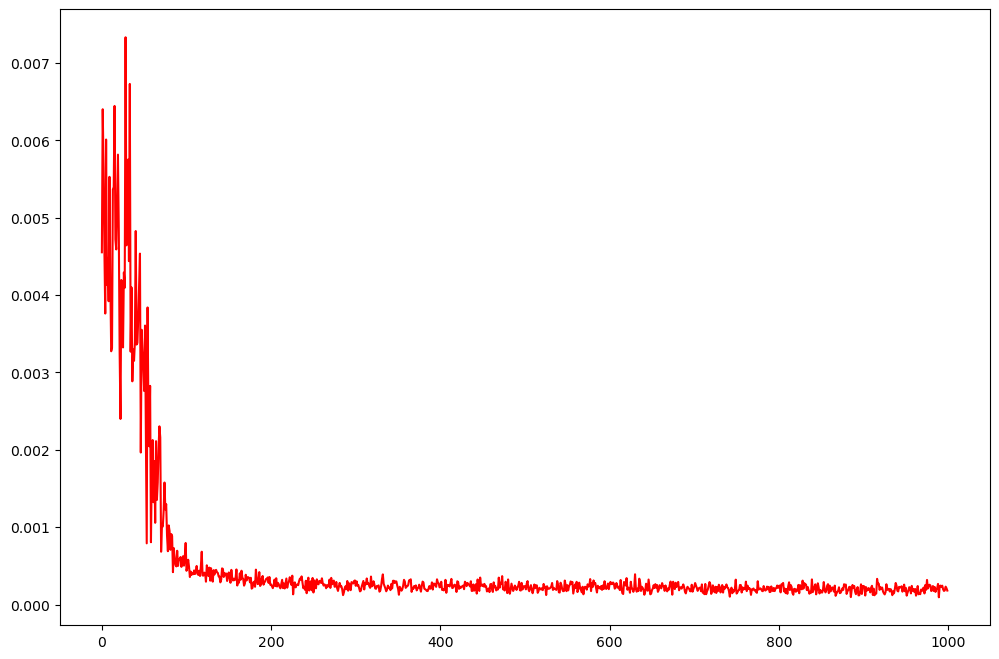

In [255]:
#訓練
# rnn = torch.load('rnn.pkl')

losses = []


optimizer = torch.optim.Adam(rnns[LABEL].parameters(), lr=LR) # optimize all cnn parameters
loss_func = nn.MSELoss()
for step in range(EPOCH):
    for tx, ty in train_loader:
        optimizer.zero_grad() # clear gradients for this training step
        # print(tx.shape)
        # print(tx)
        output,(h_n,c_n) = rnns[LABEL](tx)
        ty=torch.squeeze(ty)
        # print(ty.shape)
        # print(torch.squeeze(output[:,-1,:]).shape)
        loss = loss_func(torch.squeeze(output[:,-1,:]), ty)
        # print(loss)

        loss.backward() # back propagation, compute gradients
        optimizer.step()
    losses.append(loss.item()/BATCH_SIZE)
    print(step, losses[-1])
    if step % 10:
        torch.save(rnns[LABEL], f'rnn_{LABEL}mul+2330.pt')
torch.save(rnns[LABEL], f'rnn_{LABEL}mul+2330.pt')
plt.figure(figsize=(12,8))
plt.plot(np.array(losses), 'r')
plt.show()

In [256]:
test_feature, test_label, df_index= getTestData(df, FEATURES, LABEL, days_before=DAYS_BEFORE, train_end=TRAIN_END)
# flatern each day in train data
test_feature_tensor = torch.Tensor(np.array(test_feature.values.tolist()))
test_label_tensor = torch.Tensor(np.array(test_label.values.tolist()))
# 创建 dataloader
# print(train_feature_tensor)
# print(train_label_tensor)
test_set = TrainSet(test_feature_tensor, test_label_tensor)
# print(train_set.__len__())
train_test_loader = DataLoader(train_set, batch_size=1, shuffle=False)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)

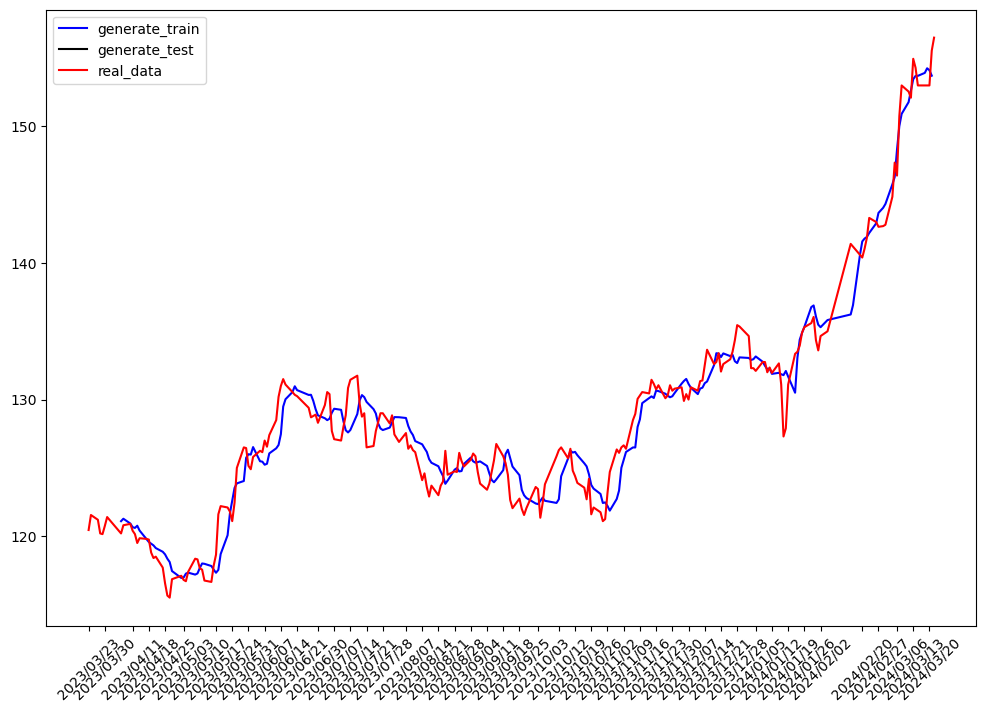

In [257]:
generate_data_train = []
generate_data_test = []
# 测试数据开始的索引
test_start = len(all_series) + TRAIN_END
# 对所有的数据进行相同的归一化
train_mean = all_series.mean()
train_std = all_series.std()
all_series_std = (all_series - train_mean) / train_std
all_series_std = torch.Tensor(all_series_std)
for tx, ty in train_test_loader:
    out, (h_n,c_n) = rnns[LABEL].predict(tx)
#     print(out.detach().flatten()[-1])
    generate_data_train.append(out.detach().flatten()[-1] * train_std + train_mean)
for tx, ty in test_loader:
    out, (h_n,c_n) = rnns[LABEL].predict(tx)
    generate_data_test.append(out.detach().flatten()[-1] * train_std + train_mean)

plt.figure(figsize=(12,8))
plt.plot(df_index[DAYS_BEFORE: TRAIN_END], generate_data_train, 'b', label='generate_train', )
plt.plot(df_index[TRAIN_END:], generate_data_test, 'k', label='generate_test')
plt.plot(df_index, all_series_std.clone().numpy()* train_std + train_mean, 'r', label='real_data')
# 设置 X 轴的刻度
plt.xticks(df_index[::5], pd.to_datetime(df_index[::5]).strftime('%Y/%m/%d'),rotation=45)
# 隐藏 X 轴的次刻度
# plt.minorticks_off()
plt.legend()
plt.show()


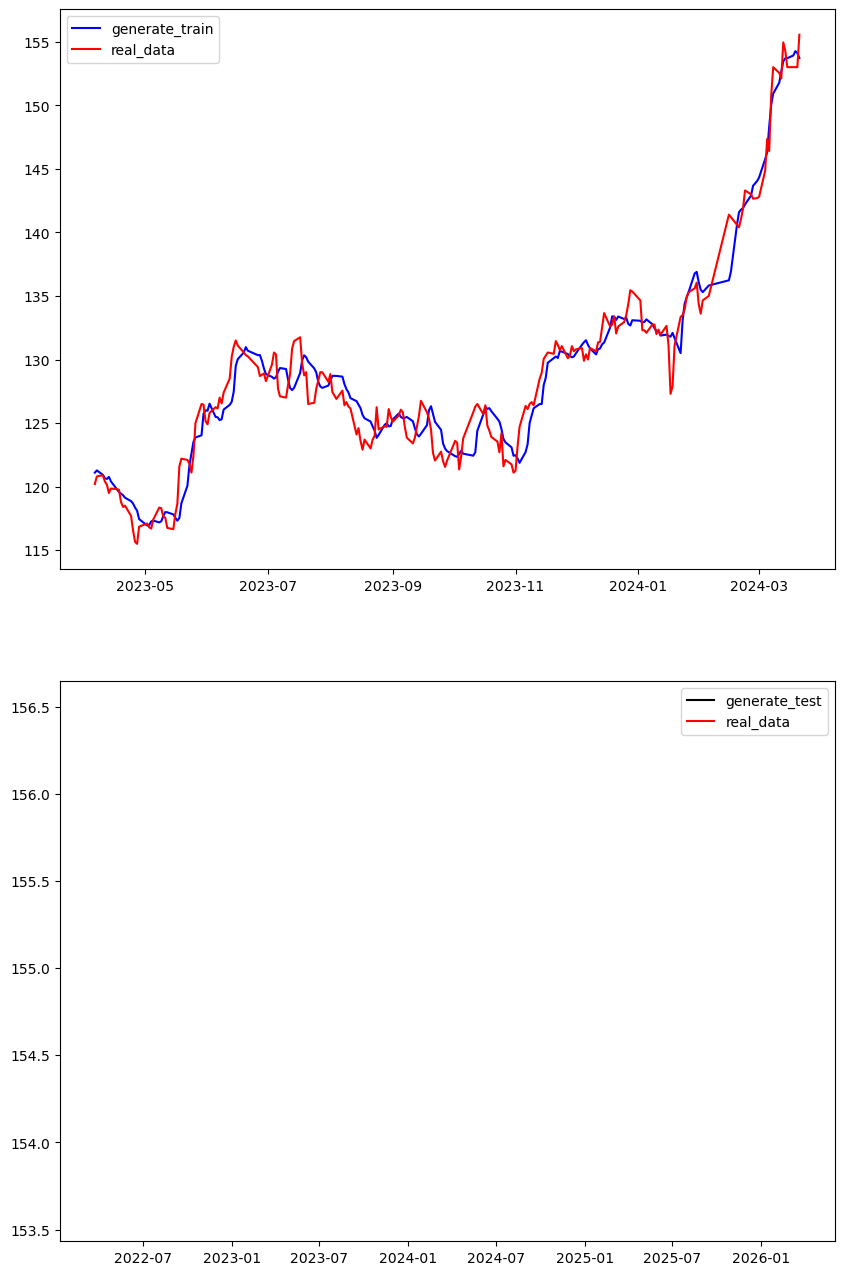

In [258]:
plt.figure(figsize=(10,16))

plt.subplot(2,1,1)
# plt.plot(df_index[100 + DAYS_BEFORE: 130 + DAYS_BEFORE], generate_data_train[100: 130], 'b', label='generate_train')
plt.plot(df_index[7: TRAIN_END], generate_data_train[:], 'b', label='generate_train')
# plt.plot(df_index[100 + DAYS_BEFORE: 130 + DAYS_BEFORE], (all_series.clone().numpy()* train_std + train_mean)[100 + DAYS_BEFORE: 130 + DAYS_BEFORE], 'r', label='real_data')
plt.plot(df_index[7:TRAIN_END], (all_series_std.clone().numpy()* train_std + train_mean)[7: TRAIN_END], 'r', label='real_data')
plt.legend()

plt.subplot(2,1,2)
plt.plot(df_index[TRAIN_END :], generate_data_test[:], 'k', label='generate_test')
plt.plot(df_index[TRAIN_END:], (all_series_std.clone().numpy()* train_std + train_mean)[TRAIN_END :], 'r', label='real_data')
plt.legend()

plt.show()

# Adj Close

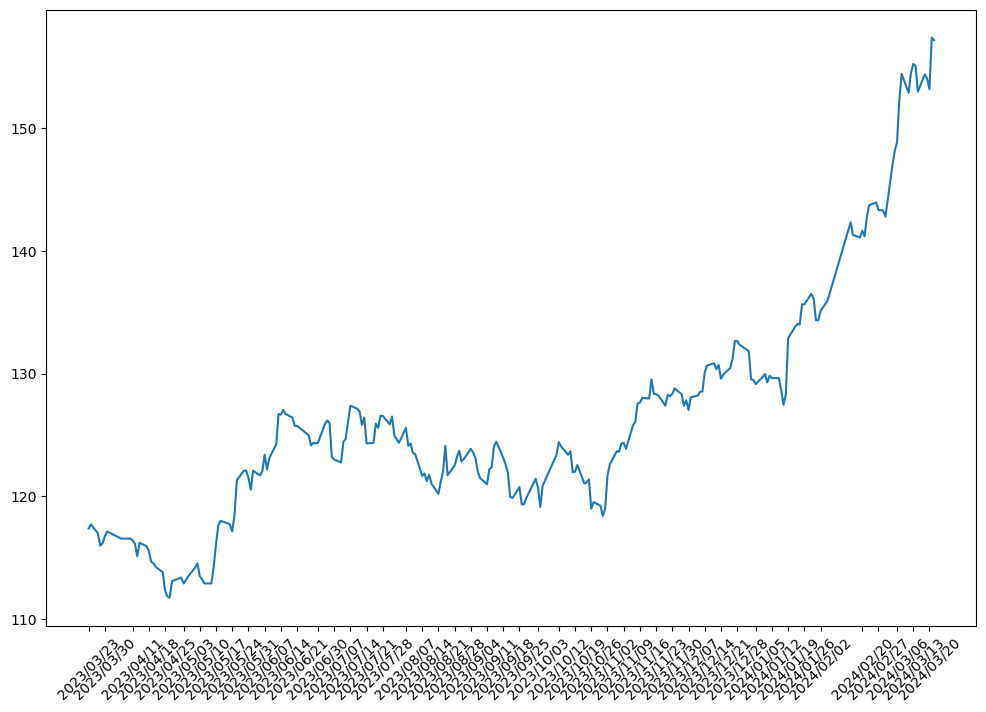

In [259]:
LABEL =  "Adj Close"

# 数据集建立
train_feature, train_label, df_index= getData(df, FEATURES, LABEL, days_before=DAYS_BEFORE, train_end=TRAIN_END)
#print(train_feature)
# 获取所有原始数据
all_series = np.array(df[LABEL].tolist())
# 绘制原始数据的图
plt.figure(figsize=(12,8))
plt.plot(df_index, all_series, label='real-data')
# 设置 X 轴的刻度
plt.xticks(df_index[::5], pd.to_datetime(df_index[::5]).strftime('%Y/%m/%d'),rotation=45)
# 隐藏 X 轴的次刻度
plt.minorticks_off()
plt.show()

# flatern each day in train data
train_feature_tensor = torch.Tensor(np.array(train_feature.values.tolist()))
train_label_tensor = torch.Tensor(np.array(train_label.values.tolist()))
# 创建 dataloader
# print(train_feature_tensor)
# print(train_label_tensor)
train_set = TrainSet(train_feature_tensor, train_label_tensor)
# print(train_set.__len__())
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)


0 0.004774125814437866
1 0.003596787452697754
2 0.006752310395240784
3 0.00237498939037323
4 0.004318758845329285
5 0.0031761634349823
6 0.0026380014419555664
7 0.0027988028526306154
8 0.008136956691741944
9 0.00466748982667923
10 0.0063671904802322385
11 0.005149070024490356
12 0.0038735833764076233
13 0.004481168985366821
14 0.007640715837478638
15 0.00476819783449173
16 0.006810377240180969
17 0.005370967984199524
18 0.002358848601579666
19 0.005436241626739502
20 0.003374715745449066
21 0.002952424585819244
22 0.006250274777412415
23 0.001620754301548004
24 0.0030588579177856447
25 0.00551242470741272
26 0.0015483406186103821
27 0.0026809865236282347
28 0.002402172088623047
29 0.0020965051651000975
30 0.0044146525859832765
31 0.0012670911848545075
32 0.0033393874764442444
33 0.002525816857814789
34 0.003545664548873901
35 0.003135331869125366
36 0.0031931814551353454
37 0.0018210707604885102
38 0.004630282819271088
39 0.003751426637172699
40 0.005315732955932617
41 0.00268088907003

318 0.0001923617348074913
319 0.0002189338579773903
320 0.0002104238048195839
321 0.0003136003017425537
322 0.0002473442628979683
323 0.00026168631389737127
324 0.0002409777045249939
325 0.00016375115141272544
326 0.0002434873953461647
327 0.00025411084294319153
328 0.00014864111319184303
329 0.00028843233361840247
330 0.0002400141954421997
331 0.0002869434654712677
332 0.0002448383904993534
333 0.00015920720994472504
334 0.0003326136991381645
335 0.00020984046161174775
336 0.00020050985738635064
337 0.00015740299597382545
338 0.0003148506209254265
339 0.00015202565118670462
340 0.00019668875262141228
341 0.00020931707695126534
342 0.00022074449807405472
343 0.00020012030377984048
344 0.0002508542127907276
345 0.00033126305788755417
346 0.00018873857334256172
347 0.00020917147397994995
348 0.00018598008900880814
349 0.0002857368625700474
350 0.00024152573198080063
351 0.00018796542659401893
352 0.00024334171786904334
353 0.00016424475237727164
354 0.00015834858641028404
355 0.000169712

626 0.0001569760963320732
627 0.00013908873312175275
628 0.00023442333564162256
629 0.00024179235100746155
630 7.865509018301963e-05
631 0.0001287445891648531
632 0.00017397737130522728
633 0.00016912182793021201
634 0.00019692810252308846
635 0.00018218379467725752
636 0.0002178531512618065
637 0.00020322842523455619
638 0.00018196860328316687
639 0.00014372171834111213
640 0.00017499668523669244
641 0.00019285030663013458
642 0.00012583618052303792
643 0.00017573254182934761
644 0.00016771148890256881
645 0.0001608603075146675
646 0.0001739252544939518
647 0.00011395390145480633
648 0.0001784379407763481
649 0.00019645925611257552
650 0.00013404242694377898
651 0.0002484462410211563
652 0.00015530886128544807
653 0.0001854800246655941
654 0.00014115532860159874
655 0.0002069062180817127
656 0.0001739027351140976
657 0.00019416751340031624
658 0.0001566835679113865
659 0.0001970941387116909
660 0.00014747465960681438
661 0.00014971542172133922
662 0.00014770376496016978
663 0.00015660

934 0.00014661342836916447
935 0.00011541021056473256
936 0.00012697936967015266
937 0.00021284576505422592
938 0.00011845326982438564
939 0.00010147916153073311
940 0.00016662109643220902
941 0.00018891939893364907
942 0.00015132120810449124
943 0.00016348550096154213
944 0.00012826505117118358
945 0.00012378388084471225
946 0.00010089612565934658
947 0.00015883585438132287
948 0.00019298987463116645
949 8.728289976716042e-05
950 0.00020106898620724677
951 0.00016289230436086655
952 0.00012154444120824338
953 0.00017038613557815552
954 0.0001434771716594696
955 0.00010464723221957684
956 0.0001296157855540514
957 0.00022724505513906478
958 0.00019364967942237855
959 0.00020069748163223266
960 0.0001650179922580719
961 0.00016961792483925818
962 0.00015371969901025294
963 0.00024271711707115172
964 0.00014187625609338284
965 0.00017891934141516685
966 0.00014887754805386065
967 0.00010944281704723835
968 0.0001875833608210087
969 0.00011489746160805226
970 0.0001466092746704817
971 0.0

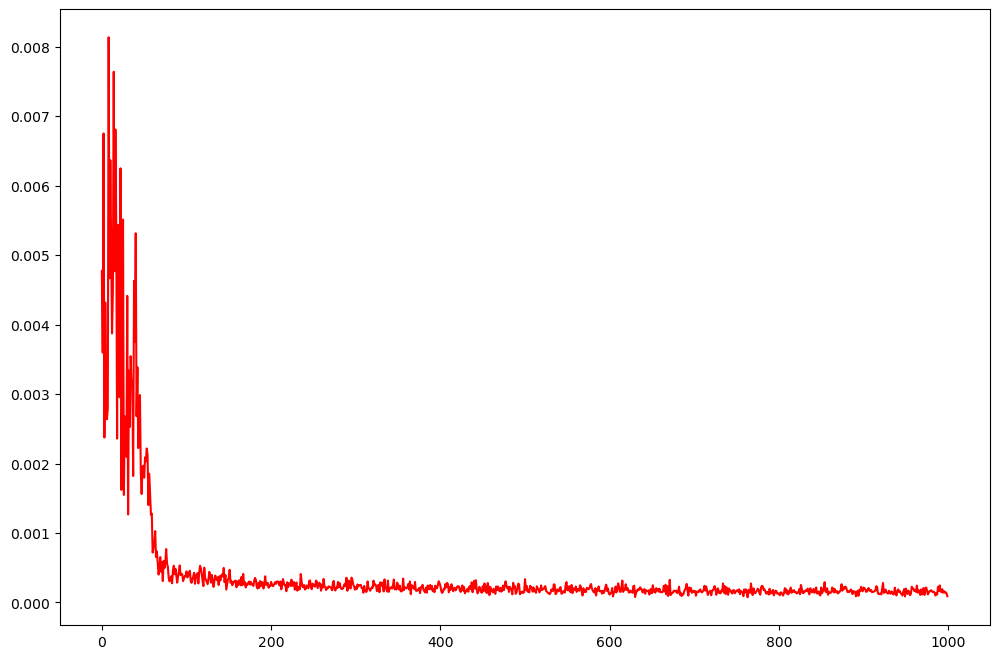

In [260]:
#訓練
# rnn = torch.load('rnn.pkl')

losses = []


optimizer = torch.optim.Adam(rnns[LABEL].parameters(), lr=LR) # optimize all cnn parameters
loss_func = nn.MSELoss()
for step in range(EPOCH):
    for tx, ty in train_loader:
        optimizer.zero_grad() # clear gradients for this training step
        # print(tx.shape)
        # print(tx)
        output,(h_n,c_n) = rnns[LABEL](tx)
        ty=torch.squeeze(ty)
        # print(ty.shape)
        # print(torch.squeeze(output[:,-1,:]).shape)
        loss = loss_func(torch.squeeze(output[:,-1,:]), ty)
        # print(loss)

        loss.backward() # back propagation, compute gradients
        optimizer.step()
    losses.append(loss.item()/BATCH_SIZE)
    print(step, losses[-1])
    if step % 10:
        torch.save(rnns[LABEL], f'rnn_{LABEL}mul+2330.pt')
torch.save(rnns[LABEL], f'rnn_{LABEL}mul+2330.pt')
plt.figure(figsize=(12,8))
plt.plot(np.array(losses), 'r')
plt.show()

In [261]:
test_feature, test_label, df_index= getTestData(df, FEATURES, LABEL, days_before=DAYS_BEFORE, train_end=TRAIN_END)
# flatern each day in train data
test_feature_tensor = torch.Tensor(np.array(test_feature.values.tolist()))
test_label_tensor = torch.Tensor(np.array(test_label.values.tolist()))
# 创建 dataloader
# print(train_feature_tensor)
# print(train_label_tensor)
test_set = TrainSet(test_feature_tensor, test_label_tensor)
# print(train_set.__len__())
train_test_loader = DataLoader(train_set, batch_size=1, shuffle=False)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)

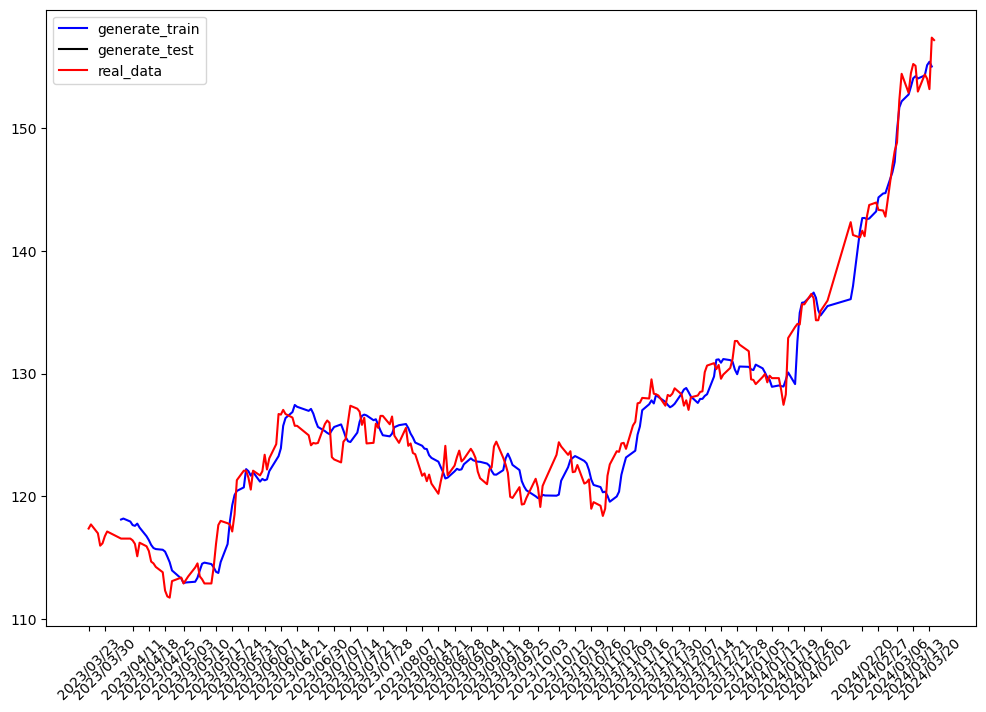

In [262]:
generate_data_train = []
generate_data_test = []
# 测试数据开始的索引
test_start = len(all_series) + TRAIN_END
# 对所有的数据进行相同的归一化
train_mean = all_series.mean()
train_std = all_series.std()
all_series_std = (all_series - train_mean) / train_std
all_series_std = torch.Tensor(all_series_std)
for tx, ty in train_test_loader:
    out, (h_n,c_n) = rnns[LABEL].predict(tx)
#     print(out.detach().flatten()[-1])
    generate_data_train.append(out.detach().flatten()[-1] * train_std + train_mean)
for tx, ty in test_loader:
    out, (h_n,c_n) = rnns[LABEL].predict(tx)
    generate_data_test.append(out.detach().flatten()[-1] * train_std + train_mean)

plt.figure(figsize=(12,8))
plt.plot(df_index[DAYS_BEFORE: TRAIN_END], generate_data_train, 'b', label='generate_train', )
plt.plot(df_index[TRAIN_END:], generate_data_test, 'k', label='generate_test')
plt.plot(df_index, all_series_std.clone().numpy()* train_std + train_mean, 'r', label='real_data')
# 设置 X 轴的刻度
plt.xticks(df_index[::5], pd.to_datetime(df_index[::5]).strftime('%Y/%m/%d'),rotation=45)
# 隐藏 X 轴的次刻度
# plt.minorticks_off()
plt.legend()
plt.show()


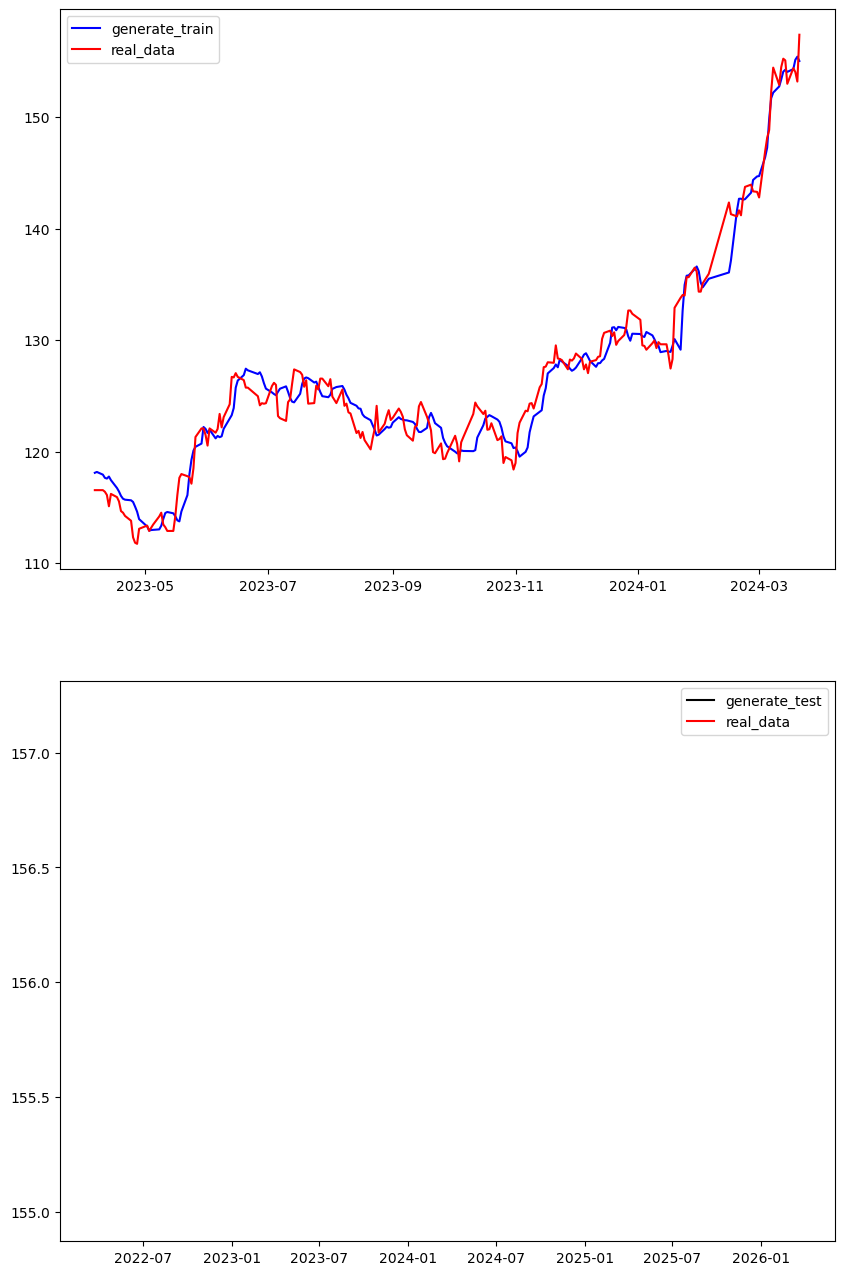

In [263]:
plt.figure(figsize=(10,16))

plt.subplot(2,1,1)
# plt.plot(df_index[100 + DAYS_BEFORE: 130 + DAYS_BEFORE], generate_data_train[100: 130], 'b', label='generate_train')
plt.plot(df_index[7: TRAIN_END], generate_data_train[:], 'b', label='generate_train')
# plt.plot(df_index[100 + DAYS_BEFORE: 130 + DAYS_BEFORE], (all_series.clone().numpy()* train_std + train_mean)[100 + DAYS_BEFORE: 130 + DAYS_BEFORE], 'r', label='real_data')
plt.plot(df_index[7:TRAIN_END], (all_series_std.clone().numpy()* train_std + train_mean)[7: TRAIN_END], 'r', label='real_data')
plt.legend()

plt.subplot(2,1,2)
plt.plot(df_index[TRAIN_END :], generate_data_test[:], 'k', label='generate_test')
plt.plot(df_index[TRAIN_END:], (all_series_std.clone().numpy()* train_std + train_mean)[TRAIN_END :], 'r', label='real_data')
plt.legend()

plt.show()

# Close

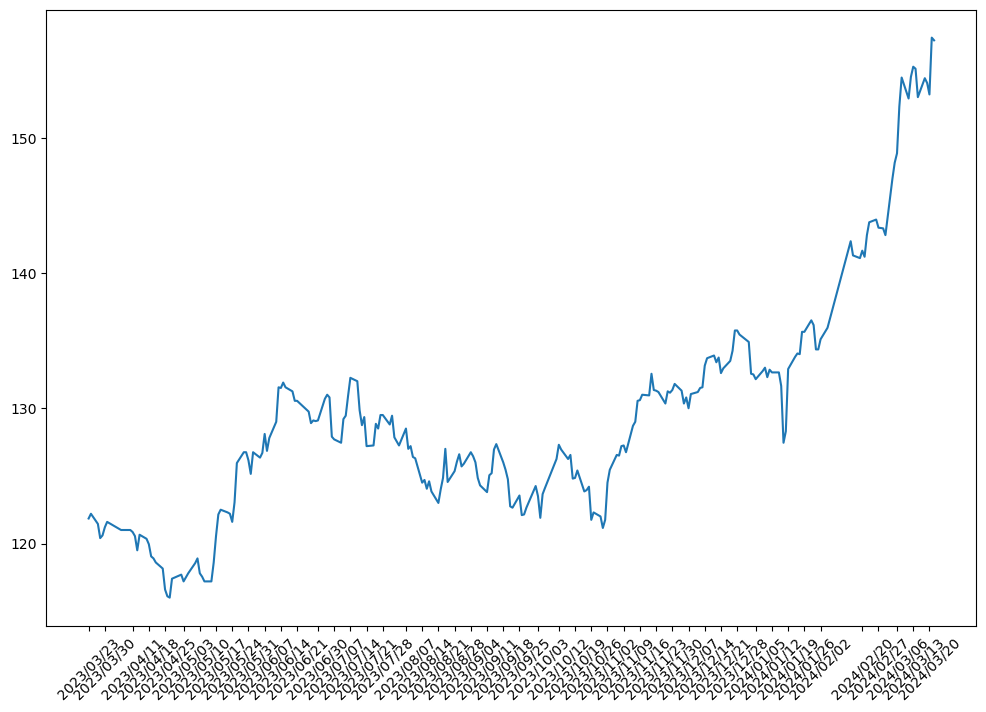

In [264]:
LABEL =  "Close"

# 数据集建立
train_feature, train_label, df_index= getData(df, FEATURES, LABEL, days_before=DAYS_BEFORE, train_end=TRAIN_END)
#print(train_feature)
# 获取所有原始数据
all_series = np.array(df[LABEL].tolist())
# 绘制原始数据的图
plt.figure(figsize=(12,8))
plt.plot(df_index, all_series, label='real-data')
# 设置 X 轴的刻度
plt.xticks(df_index[::5], pd.to_datetime(df_index[::5]).strftime('%Y/%m/%d'),rotation=45)
# 隐藏 X 轴的次刻度
plt.minorticks_off()
plt.show()

# flatern each day in train data
train_feature_tensor = torch.Tensor(np.array(train_feature.values.tolist()))
train_label_tensor = torch.Tensor(np.array(train_label.values.tolist()))
# 创建 dataloader
# print(train_feature_tensor)
# print(train_label_tensor)
train_set = TrainSet(train_feature_tensor, train_label_tensor)
# print(train_set.__len__())
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)


0 0.0026876872777938845
1 0.005030786395072937
2 0.006894148588180542
3 0.007954574823379516
4 0.004072953760623932
5 0.0032972705364227293
6 0.0016924150288105011
7 0.00448637992143631
8 0.00673058807849884
9 0.004449675083160401
10 0.004086973369121552
11 0.0034081459045410155
12 0.003750331699848175
13 0.001974021345376968
14 0.00214029461145401
15 0.005966452956199646
16 0.0016619144380092621
17 0.004085627496242523
18 0.005261017084121704
19 0.002947602868080139
20 0.0030771097540855407
21 0.004021216034889221
22 0.0035945945978164673
23 0.004771195948123932
24 0.0031274229288101195
25 0.005261048674583435
26 0.0049979034066200256
27 0.004405977725982666
28 0.0033245143294334412
29 0.002995542883872986
30 0.004426637291908264
31 0.0033116123080253602
32 0.0028626367449760435
33 0.002336011826992035
34 0.0023539963364601134
35 0.0034985890984535217
36 0.004257304072380066
37 0.0031250813603401185
38 0.0021936534345149993
39 0.0039376914501190186
40 0.0033328792452812193
41 0.004374

318 0.000256190113723278
319 0.00032009448856115344
320 0.0003069138899445534
321 0.00016757458448410034
322 0.00029596196487545966
323 0.0002805055305361748
324 0.00026250991970300675
325 0.0002525831386446953
326 0.00019870223477482795
327 0.0003022144176065922
328 0.0002067018672823906
329 0.00025388265028595923
330 0.0002948571927845478
331 0.0002285894751548767
332 0.0002665955759584904
333 0.00022897299379110337
334 0.00019954893738031388
335 0.00025981083512306214
336 0.00022408604621887207
337 0.00035727664828300477
338 0.00022766586393117903
339 0.00027463670819997786
340 0.00018244324252009392
341 0.00020104916766285896
342 0.0002969006821513176
343 0.00022804927080869675
344 0.0003031988814473152
345 0.0002364032156765461
346 0.0002660319022834301
347 0.00021568542346358298
348 0.00031330619007349016
349 0.00022273560985922814
350 0.00022343534976243973
351 0.0002770710922777653
352 0.00024663655087351797
353 0.0002280304953455925
354 0.00034161534160375594
355 0.00027544880

626 0.00017754599452018738
627 0.00029757890850305556
628 0.0002897146344184875
629 0.00024732001125812533
630 0.00019505241885781288
631 0.00022099513560533524
632 0.00020409487187862397
633 0.00021451618522405624
634 0.00015309358015656472
635 0.0002193193882703781
636 0.0002486640773713589
637 0.0001961209252476692
638 0.0002870262041687965
639 0.0002889190800487995
640 0.00028475968167185784
641 0.00016654951497912406
642 0.00016765808686614037
643 0.00021760158240795137
644 0.0001759282499551773
645 0.00019418250769376755
646 0.0003011689148843288
647 0.00022179871797561645
648 0.00026110460981726647
649 0.000259234718978405
650 0.00016216397285461425
651 0.00017224729061126709
652 0.00025037452578544615
653 0.00019605474546551704
654 0.00038099870085716247
655 0.0003096659108996391
656 0.0003512531891465187
657 0.00023029247298836708
658 0.00016795167699456214
659 0.00015762975439429283
660 0.00024070486426353455
661 0.0002398259751498699
662 0.00018742416054010392
663 0.00018220

934 0.00019153375178575515
935 0.00018450727686285972
936 0.00018005149438977242
937 0.00020725240930914878
938 0.00021899597719311715
939 0.00023610208183526992
940 0.00021707560867071152
941 0.0001427653059363365
942 0.00018253510817885398
943 0.00022844867780804634
944 0.00027742259204387664
945 0.0002056875452399254
946 0.00020476868376135827
947 0.00016319742426276206
948 0.00014083259738981724
949 0.00026690663769841195
950 0.00021851560100913047
951 0.00015961915254592896
952 0.0002483911439776421
953 0.00019735412672162056
954 0.00019588887691497802
955 0.00018204567953944206
956 0.000164305716753006
957 0.00016945531591773034
958 0.0001664907857775688
959 0.0002207883447408676
960 0.0001391340885311365
961 0.0003238639235496521
962 0.0001354492176324129
963 0.00023172510787844658
964 0.00020164253190159797
965 0.0001962258480489254
966 0.0001325957477092743
967 0.00020315852016210555
968 0.0002657570503652096
969 0.00011349777691066265
970 0.00015182357281446458
971 0.00025571

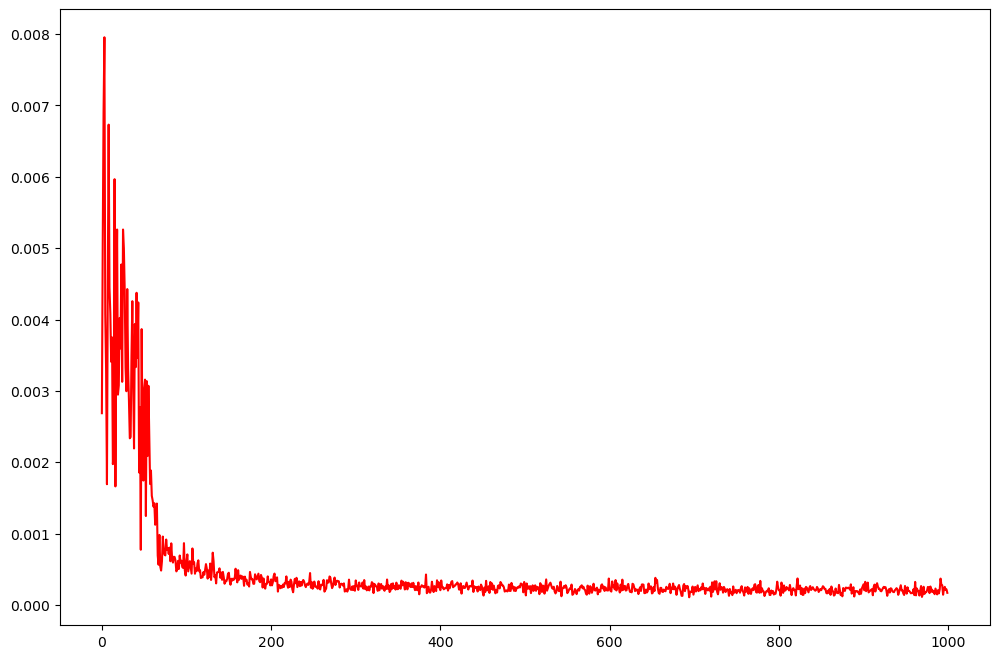

In [265]:
#訓練
# rnn = torch.load('rnn.pkl')

losses = []



optimizer = torch.optim.Adam(rnns[LABEL].parameters(), lr=LR) # optimize all cnn parameters
loss_func = nn.MSELoss()
for step in range(EPOCH):
    for tx, ty in train_loader:
        optimizer.zero_grad() # clear gradients for this training step
        # print(tx.shape)
        # print(tx)
        output,(h_n,c_n) = rnns[LABEL](tx)
        ty=torch.squeeze(ty)
        # print(ty.shape)
        # print(torch.squeeze(output[:,-1,:]).shape)
        loss = loss_func(torch.squeeze(output[:,-1,:]), ty)
        # print(loss)

        loss.backward() # back propagation, compute gradients
        optimizer.step()
    losses.append(loss.item()/BATCH_SIZE)
    print(step, losses[-1])
    if step % 10:
        torch.save(rnns[LABEL], f'rnn_{LABEL}mul+2330.pt')
torch.save(rnns[LABEL], f'rnn_{LABEL}mul+2330.pt')
plt.figure(figsize=(12,8))
plt.plot(np.array(losses), 'r')
plt.show()

In [266]:
test_feature, test_label, df_index= getTestData(df, FEATURES, LABEL, days_before=DAYS_BEFORE, train_end=TRAIN_END)
# flatern each day in train data
test_feature_tensor = torch.Tensor(np.array(test_feature.values.tolist()))
test_label_tensor = torch.Tensor(np.array(test_label.values.tolist()))
# 创建 dataloader
# print(train_feature_tensor)
# print(train_label_tensor)
test_set = TrainSet(test_feature_tensor, test_label_tensor)
# print(train_set.__len__())
train_test_loader = DataLoader(train_set, batch_size=1, shuffle=False)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)

ValueError: x and y must have same first dimension, but have shapes (244,) and (235,)

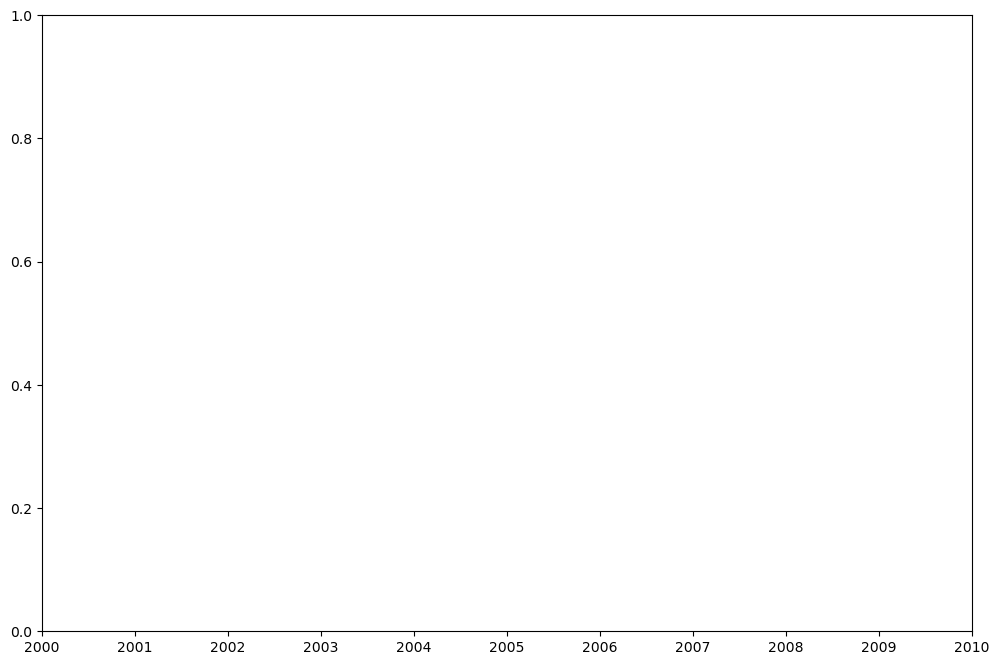

In [284]:
generate_data_train = []
generate_data_test = []
# 测试数据开始的索引
test_start = len(all_series) + TRAIN_END
# 对所有的数据进行相同的归一化
train_mean = all_series.mean()
train_std = all_series.std()
all_series_std = (all_series - train_mean) / train_std
all_series_std = torch.Tensor(all_series_std)
for tx, ty in train_test_loader:
    out, (h_n,c_n) = rnns[LABEL].predict(tx)
#     print(out.detach().flatten()[-1])
    generate_data_train.append(out.detach().flatten()[-1] * train_std + train_mean)
for tx, ty in test_loader:
    out, (h_n,c_n) = rnns[LABEL].predict(tx)
    generate_data_test.append(out.detach().flatten()[-1] * train_std + train_mean)

plt.figure(figsize=(12,8))
plt.plot(df_index[DAYS_BEFORE: TRAIN_END], generate_data_train, 'b', label='generate_train', )
plt.plot(df_index[TRAIN_END:], generate_data_test, 'k', label='generate_test')

plt.plot(df_index, all_series_std.clone().numpy()* train_std + train_mean, 'r', label='real_data')
# 设置 X 轴的刻度
plt.xticks(df_index[::5], pd.to_datetime(df_index[::5]).strftime('%Y/%m/%d'),rotation=45)
# 隐藏 X 轴的次刻度
# plt.minorticks_off()
plt.legend()
plt.show()


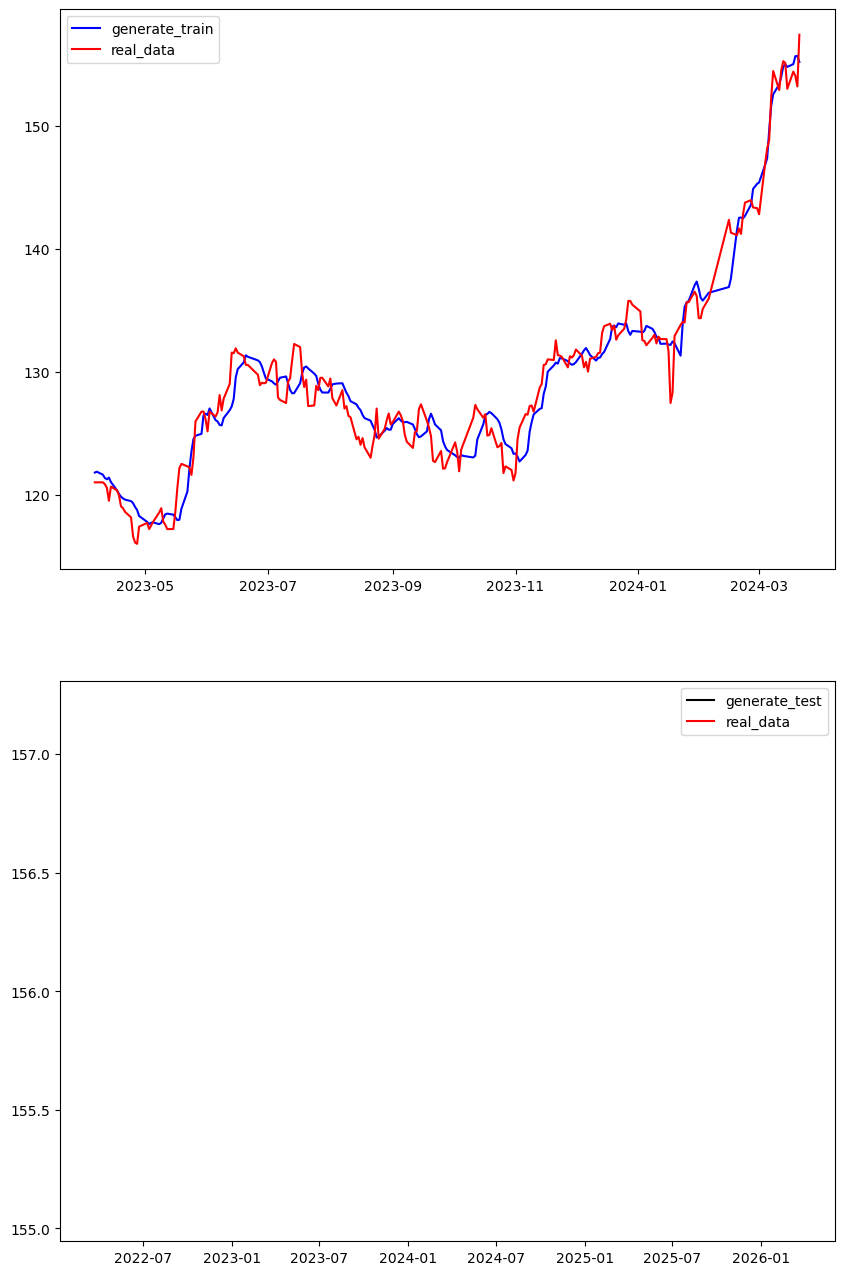

In [268]:
plt.figure(figsize=(10,16))

plt.subplot(2,1,1)
# plt.plot(df_index[100 + DAYS_BEFORE: 130 + DAYS_BEFORE], generate_data_train[100: 130], 'b', label='generate_train')
plt.plot(df_index[7: TRAIN_END], generate_data_train[:], 'b', label='generate_train')
# plt.plot(df_index[100 + DAYS_BEFORE: 130 + DAYS_BEFORE], (all_series.clone().numpy()* train_std + train_mean)[100 + DAYS_BEFORE: 130 + DAYS_BEFORE], 'r', label='real_data')
plt.plot(df_index[7:TRAIN_END], (all_series_std.clone().numpy()* train_std + train_mean)[7: TRAIN_END], 'r', label='real_data')
plt.legend()

plt.subplot(2,1,2)
plt.plot(df_index[TRAIN_END :], generate_data_test[:], 'k', label='generate_test')
plt.plot(df_index[TRAIN_END:], (all_series_std.clone().numpy()* train_std + train_mean)[TRAIN_END :], 'r', label='real_data')
plt.legend()

plt.show()

# Volume

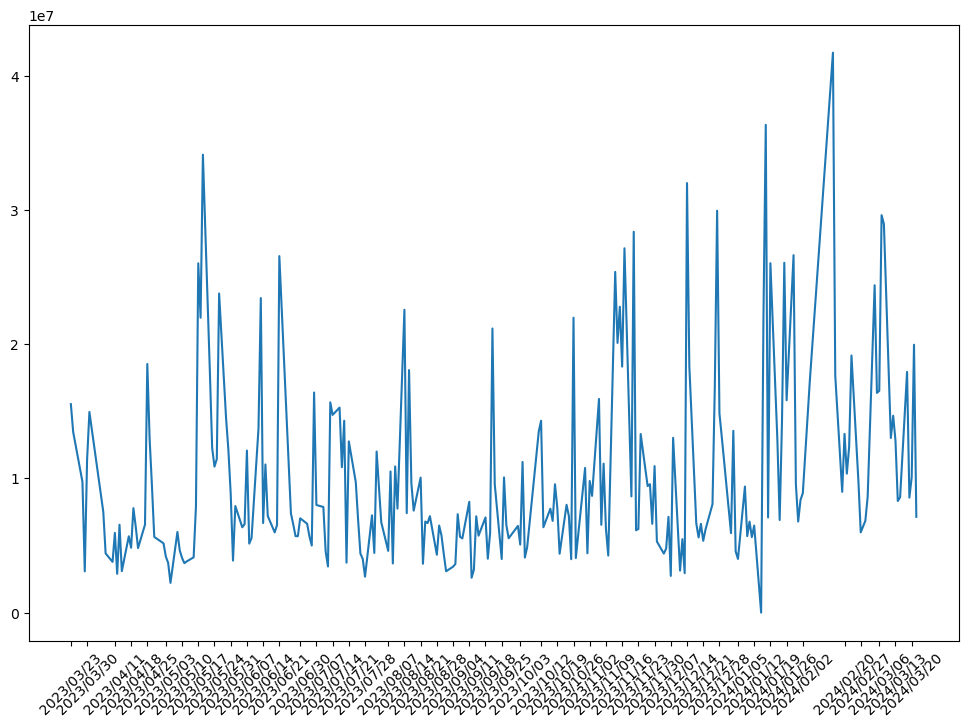

In [269]:
LABEL =  "Volume"

# 数据集建立
train_feature, train_label, df_index= getData(df, FEATURES, LABEL, days_before=DAYS_BEFORE, train_end=TRAIN_END)
#print(train_feature)
# 获取所有原始数据
all_series = np.array(df[LABEL].tolist())
# 绘制原始数据的图
plt.figure(figsize=(12,8))
plt.plot(df_index, all_series, label='real-data')
# 设置 X 轴的刻度
plt.xticks(df_index[::5], pd.to_datetime(df_index[::5]).strftime('%Y/%m/%d'),rotation=45)
# 隐藏 X 轴的次刻度
plt.minorticks_off()
plt.show()

# flatern each day in train data
train_feature_tensor = torch.Tensor(np.array(train_feature.values.tolist()))
train_label_tensor = torch.Tensor(np.array(train_label.values.tolist()))
# 创建 dataloader
# print(train_feature_tensor)
# print(train_label_tensor)
train_set = TrainSet(train_feature_tensor, train_label_tensor)
# print(train_set.__len__())
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)


0 0.006618388891220093
1 0.004491111040115356
2 0.006961526870727539
3 0.005657833218574524
4 0.004386756122112274
5 0.004591025114059448
6 0.007979873418807983
7 0.003453381359577179
8 0.003870682716369629
9 0.003706725239753723
10 0.006495195627212525
11 0.004838484525680542
12 0.007645546793937683
13 0.0058536136150360105
14 0.0034902429580688475
15 0.0034734207391738893
16 0.006297091245651245
17 0.004257583320140839
18 0.007404312491416931
19 0.004230821132659912
20 0.00488188773393631
21 0.002855093777179718
22 0.004519753754138946
23 0.00459089607000351
24 0.005682198405265808
25 0.0029025739431381226
26 0.0076436161994934086
27 0.0030204424262046813
28 0.005504810810089111
29 0.0060335642099380495
30 0.008610840439796447
31 0.006694843769073486
32 0.004865449070930481
33 0.005547885298728943
34 0.006944867968559265
35 0.0066676467657089235
36 0.002819720804691315
37 0.003213362991809845
38 0.006315533518791199
39 0.005676921010017395
40 0.0038600167632102966
41 0.00503626167774

330 0.006422128677368164
331 0.0032795792818069457
332 0.003038061857223511
333 0.0032206660509109496
334 0.005845727920532226
335 0.004976305961608887
336 0.0037113472819328306
337 0.003568589985370636
338 0.004831006228923798
339 0.006063622832298279
340 0.003178669810295105
341 0.005377473831176757
342 0.003980100154876709
343 0.0034753802418708802
344 0.003951351940631866
345 0.005154470205307007
346 0.003614068031311035
347 0.0028511545062065123
348 0.004091847836971283
349 0.00580137550830841
350 0.0031661015748977663
351 0.00598518431186676
352 0.0028323468565940855
353 0.004987682402133942
354 0.0047225385904312136
355 0.006891798973083496
356 0.002818789780139923
357 0.007774655818939209
358 0.005261417627334595
359 0.0037431973218917847
360 0.006253135800361634
361 0.00306258499622345
362 0.006008502840995788
363 0.004219498336315155
364 0.004198235869407654
365 0.005761346817016602
366 0.00468505471944809
367 0.006419873833656311
368 0.004385172426700592
369 0.00258351773023

656 0.0029216769337654116
657 0.005497903823852539
658 0.00481851726770401
659 0.004647238552570343
660 0.0034912145137786866
661 0.004130544364452362
662 0.004609478116035462
663 0.0036360329389572145
664 0.002448156625032425
665 0.00480380892753601
666 0.007461215257644653
667 0.002641158103942871
668 0.005350677967071533
669 0.0015950432419776916
670 0.003364359438419342
671 0.0033358553051948546
672 0.004888644218444824
673 0.00389833927154541
674 0.001868434101343155
675 0.005226685404777527
676 0.002950531244277954
677 0.005601065158843994
678 0.003468497097492218
679 0.0040595194697380065
680 0.0035215750336647033
681 0.005057346820831299
682 0.005672563314437867
683 0.003663722574710846
684 0.0040577778220176695
685 0.0017452742159366607
686 0.0021043844521045686
687 0.002294544726610184
688 0.002072518765926361
689 0.0034849128127098085
690 0.005020991563796997
691 0.004161044955253601
692 0.00359620600938797
693 0.005256967544555664
694 0.0038652491569519045
695 0.00712377786

980 0.0038132503628730773
981 0.004024622440338135
982 0.0032928648591041567
983 0.006024888753890991
984 0.0023794305324554444
985 0.00555206835269928
986 0.00460723340511322
987 0.003521691858768463
988 0.0027517315745353697
989 0.003879495859146118
990 0.0017482076585292816
991 0.007373731136322021
992 0.005471447706222534
993 0.004739341139793396
994 0.005809679031372071
995 0.003245900869369507
996 0.004313155710697174
997 0.00457204669713974
998 0.0021678027510643005
999 0.0029538488388061524


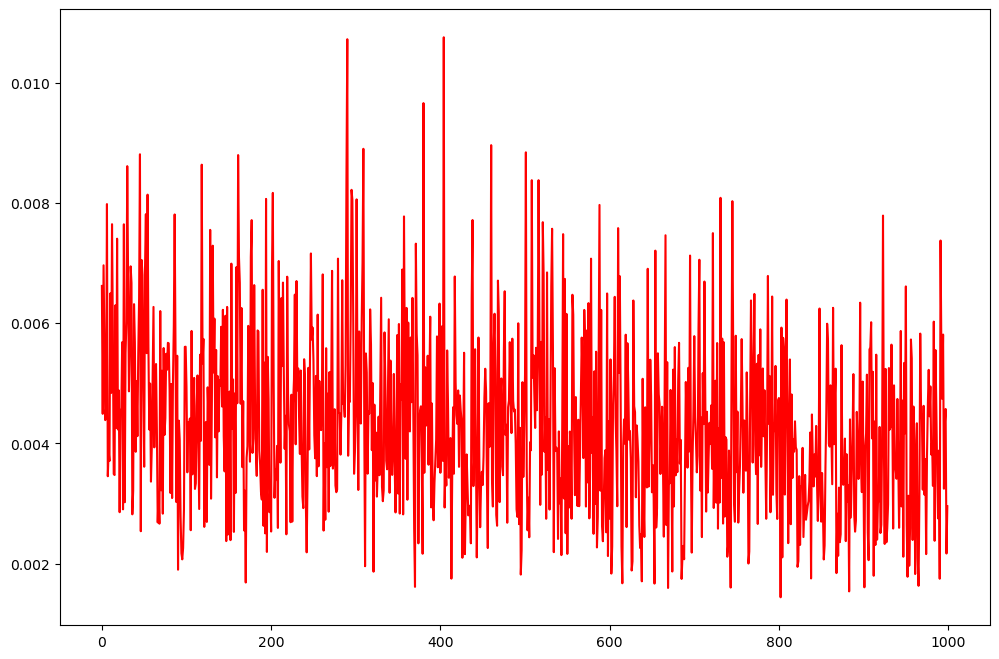

In [270]:
#訓練
# rnn = torch.load('rnn.pkl')

losses = []

rnn = LSTM()

optimizer = torch.optim.Adam(rnn.parameters(), lr=LR) # optimize all cnn parameters
loss_func = nn.MSELoss()
for step in range(EPOCH):
    for tx, ty in train_loader:
        optimizer.zero_grad() # clear gradients for this training step
        # print(tx.shape)
        # print(tx)
        output,(h_n,c_n) = rnn(tx)
        ty=torch.squeeze(ty)
        # print(ty.shape)
        # print(torch.squeeze(output[:,-1,:]).shape)
        loss = loss_func(torch.squeeze(output[:,-1,:]), ty)
        # print(loss)

        loss.backward() # back propagation, compute gradients
        optimizer.step()
    losses.append(loss.item()/BATCH_SIZE)
    print(step, losses[-1])
    if step % 10:
        torch.save(rnn, f'rnn_{LABEL}mul+2330.pt')
torch.save(rnn, f'rnn_{LABEL}mul+2330.pt')
plt.figure(figsize=(12,8))
plt.plot(np.array(losses), 'r')
plt.show()

In [271]:
test_feature, test_label, df_index= getTestData(df, FEATURES, LABEL, days_before=DAYS_BEFORE, train_end=TRAIN_END)
# flatern each day in train data
test_feature_tensor = torch.Tensor(np.array(test_feature.values.tolist()))
test_label_tensor = torch.Tensor(np.array(test_label.values.tolist()))
# 创建 dataloader
# print(train_feature_tensor)
# print(train_label_tensor)
test_set = TrainSet(test_feature_tensor, test_label_tensor)
# print(train_set.__len__())
train_test_loader = DataLoader(train_set, batch_size=1, shuffle=False)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)

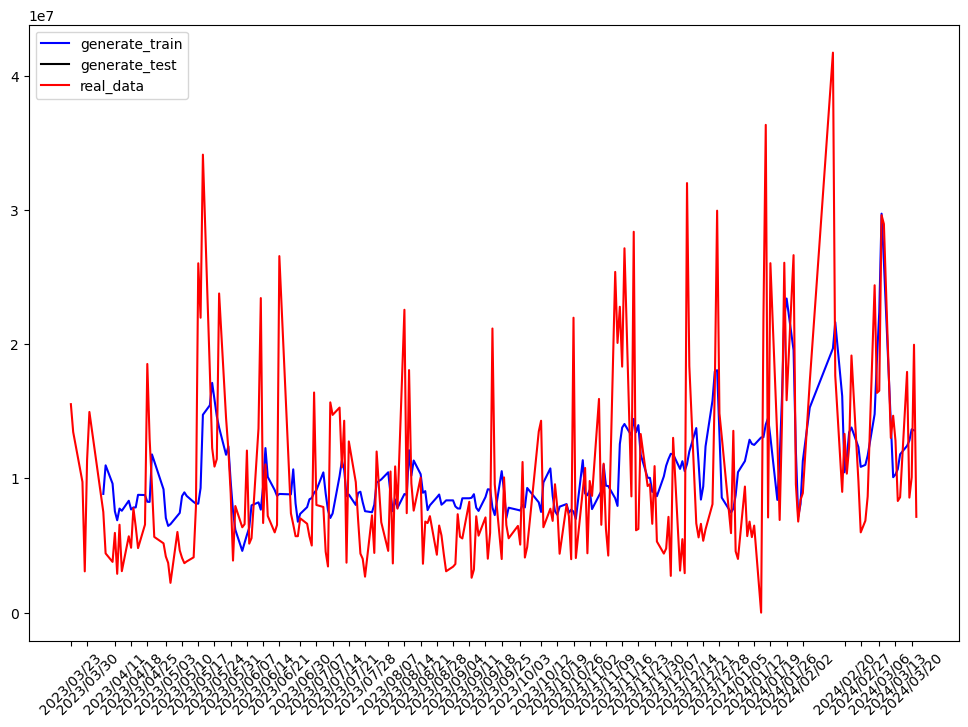

In [272]:
generate_data_train = []
generate_data_test = []
# 测试数据开始的索引
test_start = len(all_series) + TRAIN_END
# 对所有的数据进行相同的归一化
train_mean = all_series.mean()
train_std = all_series.std()
all_series_std = (all_series - train_mean) / train_std
all_series_std = torch.Tensor(all_series_std)
for tx, ty in train_test_loader:
    out, (h_n,c_n) = rnn.predict(tx)
#     print(out.detach().flatten()[-1])
    generate_data_train.append(out.detach().flatten()[-1] * train_std + train_mean)
for tx, ty in test_loader:
    out, (h_n,c_n) = rnn.predict(tx)
    generate_data_test.append(out.detach().flatten()[-1] * train_std + train_mean)

plt.figure(figsize=(12,8))
plt.plot(df_index[DAYS_BEFORE: TRAIN_END], generate_data_train, 'b', label='generate_train', )
plt.plot(df_index[TRAIN_END:], generate_data_test, 'k', label='generate_test')
plt.plot(df_index, all_series_std.clone().numpy()* train_std + train_mean, 'r', label='real_data')
# 设置 X 轴的刻度
plt.xticks(df_index[::5], pd.to_datetime(df_index[::5]).strftime('%Y/%m/%d'),rotation=45)
# 隐藏 X 轴的次刻度
# plt.minorticks_off()
plt.legend()
plt.show()


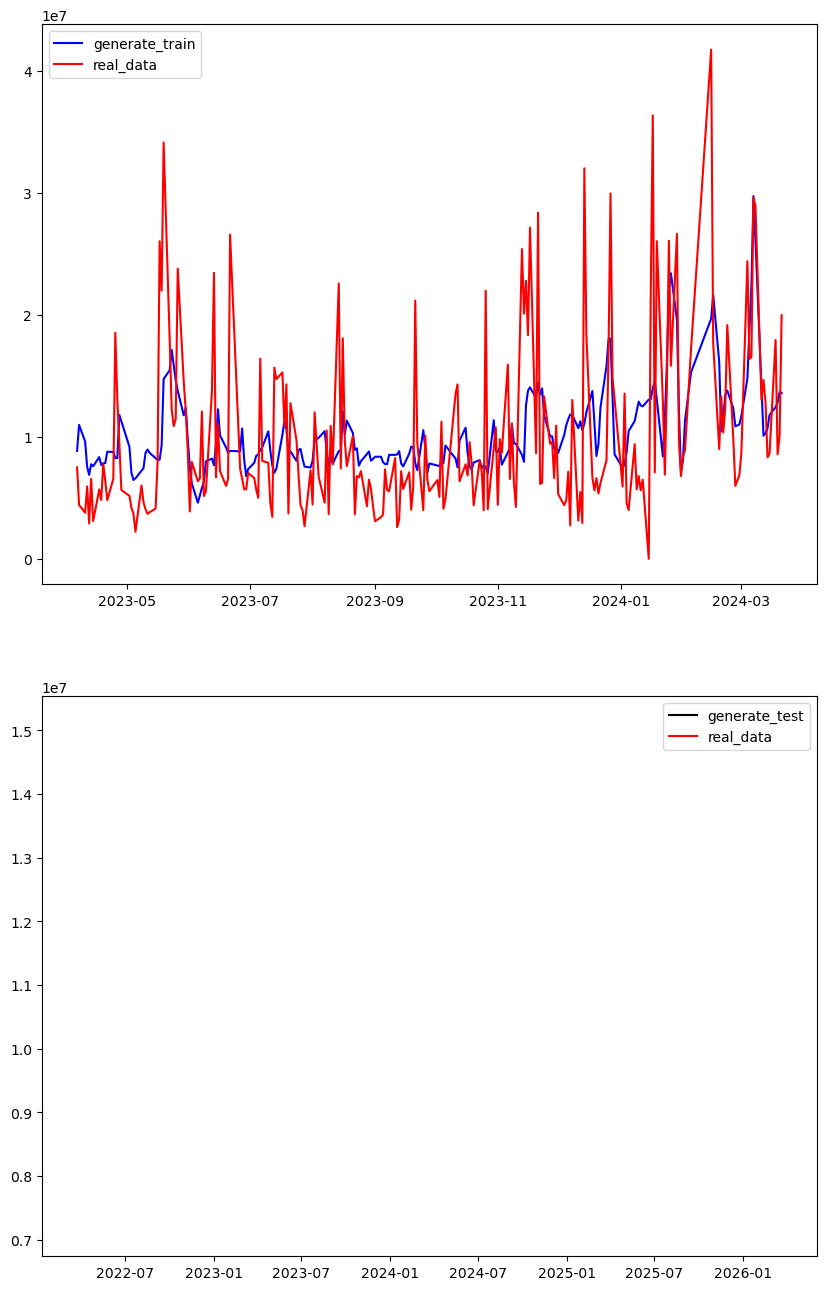

In [273]:
plt.figure(figsize=(10,16))

plt.subplot(2,1,1)
# plt.plot(df_index[100 + DAYS_BEFORE: 130 + DAYS_BEFORE], generate_data_train[100: 130], 'b', label='generate_train')
plt.plot(df_index[7: TRAIN_END], generate_data_train[:], 'b', label='generate_train')
# plt.plot(df_index[100 + DAYS_BEFORE: 130 + DAYS_BEFORE], (all_series.clone().numpy()* train_std + train_mean)[100 + DAYS_BEFORE: 130 + DAYS_BEFORE], 'r', label='real_data')
plt.plot(df_index[7:TRAIN_END], (all_series_std.clone().numpy()* train_std + train_mean)[7: TRAIN_END], 'r', label='real_data')
plt.legend()

plt.subplot(2,1,2)
plt.plot(df_index[TRAIN_END :], generate_data_test[:], 'k', label='generate_test')
plt.plot(df_index[TRAIN_END:], (all_series_std.clone().numpy()* train_std + train_mean)[TRAIN_END :], 'r', label='real_data')
plt.legend()

plt.show()

# Volume_2330

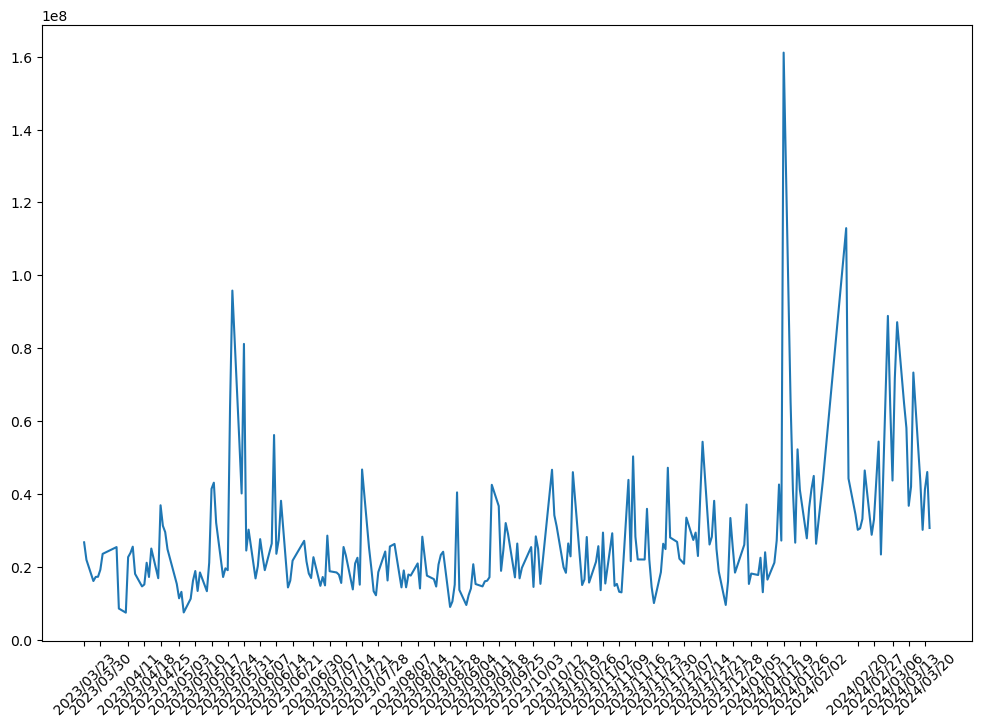

In [274]:
LABEL =  "Volume_2330"

# 数据集建立
train_feature, train_label, df_index= getData(df, FEATURES, LABEL, days_before=DAYS_BEFORE, train_end=TRAIN_END)
#print(train_feature)
# 获取所有原始数据
all_series = np.array(df[LABEL].tolist())
# 绘制原始数据的图
plt.figure(figsize=(12,8))
plt.plot(df_index, all_series, label='real-data')
# 设置 X 轴的刻度
plt.xticks(df_index[::5], pd.to_datetime(df_index[::5]).strftime('%Y/%m/%d'),rotation=45)
# 隐藏 X 轴的次刻度
plt.minorticks_off()
plt.show()

# flatern each day in train data
train_feature_tensor = torch.Tensor(np.array(train_feature.values.tolist()))
train_label_tensor = torch.Tensor(np.array(train_label.values.tolist()))
# 创建 dataloader
# print(train_feature_tensor)
# print(train_label_tensor)
train_set = TrainSet(train_feature_tensor, train_label_tensor)
# print(train_set.__len__())
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)


0 0.009143224358558655
1 0.013090213537216186
2 0.0014618360996246338
3 0.002663569450378418
4 0.0059074491262435915
5 0.004871959686279297
6 0.004131124317646027
7 0.003951562345027923
8 0.005951002240180969
9 0.001575157791376114
10 0.006695734858512878
11 0.0025759020447731016
12 0.0163296377658844
13 0.0011417606472969054
14 0.004684008061885834
15 0.002237858027219772
16 0.003988177180290222
17 0.004543988704681396
18 0.011587522029876708
19 0.0039654988050460815
20 0.007121540904045105
21 0.005702353715896606
22 0.0010848814994096755
23 0.011908880472183227
24 0.0056699663400650024
25 0.002113753706216812
26 0.003943081498146057
27 0.004366368651390075
28 0.0015381771326065065
29 0.0037541404366493226
30 0.002728208601474762
31 0.005332333445549012
32 0.0015089157223701476
33 0.001183554083108902
34 0.0041626086831092835
35 0.01317482590675354
36 0.006625085473060608
37 0.002684873342514038
38 0.0025426623225212096
39 0.005227488279342651
40 0.0012484652549028398
41 0.00310200601

328 0.0024897395074367523
329 0.002197568416595459
330 0.0023874877393245697
331 0.0036791229248046876
332 0.002501507997512817
333 0.0024595026671886443
334 0.004471764862537384
335 0.0042244669795036315
336 0.0031605929136276243
337 0.0022414325177669524
338 0.003493770956993103
339 0.011178280115127564
340 0.002379535138607025
341 0.004425769448280334
342 0.0034421491622924805
343 0.003537917137145996
344 0.0014599661529064178
345 0.0025634923577308654
346 0.004864916205406189
347 0.00425389438867569
348 0.0015511946380138398
349 0.002647770643234253
350 0.00138192817568779
351 0.0060181146860122684
352 0.0008984553813934326
353 0.00984924852848053
354 0.004253556728363037
355 0.0013689735531806945
356 0.001884326934814453
357 0.002192595303058624
358 0.002004580944776535
359 0.0018270407617092133
360 0.0022712084650993347
361 0.0042778652906417846
362 0.014098050594329834
363 0.0023509638011455537
364 0.002534254789352417
365 0.006111825108528137
366 0.0020876410603523255
367 0.009

650 0.0017277312278747559
651 0.008113628029823303
652 0.0026951485872268675
653 0.0012981446087360381
654 0.000995815172791481
655 0.0021900418400764466
656 0.007838688492774963
657 0.0028072750568389894
658 0.006989492774009704
659 0.0026703709363937378
660 0.002070494443178177
661 0.0017992593348026276
662 0.0017075031995773316
663 0.0026246502995491026
664 0.0009653957933187484
665 0.001876699924468994
666 0.0015896153450012207
667 0.010960935354232789
668 0.0006812903285026551
669 0.0015958592295646668
670 0.0039559143781661985
671 0.007666966915130615
672 0.0023417511582374574
673 0.0038306072354316713
674 0.002654368281364441
675 0.0023521848022937776
676 0.005016561150550842
677 0.0012618300318717956
678 0.004284229278564453
679 0.004338157773017884
680 0.00274693489074707
681 0.0026465320587158205
682 0.0022280129790306093
683 0.0023021619021892548
684 0.0011239543557167054
685 0.0025273242592811582
686 0.0017655777931213379
687 0.001259685754776001
688 0.002932792007923126
68

972 0.001619292050600052
973 0.001306983232498169
974 0.0011778729408979415
975 0.001966758817434311
976 0.00846806526184082
977 0.007205256819725036
978 0.0018042466044425965
979 0.00274942010641098
980 0.0026526975631713866
981 0.004654761254787445
982 0.0013714911043643952
983 0.003103809654712677
984 0.0009853572398424149
985 0.005960313081741333
986 0.007398193478584289
987 0.002558109164237976
988 0.003236711025238037
989 0.0012875302135944367
990 0.005910183787345886
991 0.004211364090442657
992 0.0021142569184303284
993 0.002687729299068451
994 0.0011109352111816407
995 0.008146708607673645
996 0.007433942556381226
997 0.0015189337730407715
998 0.001670919507741928
999 0.0013227300345897675


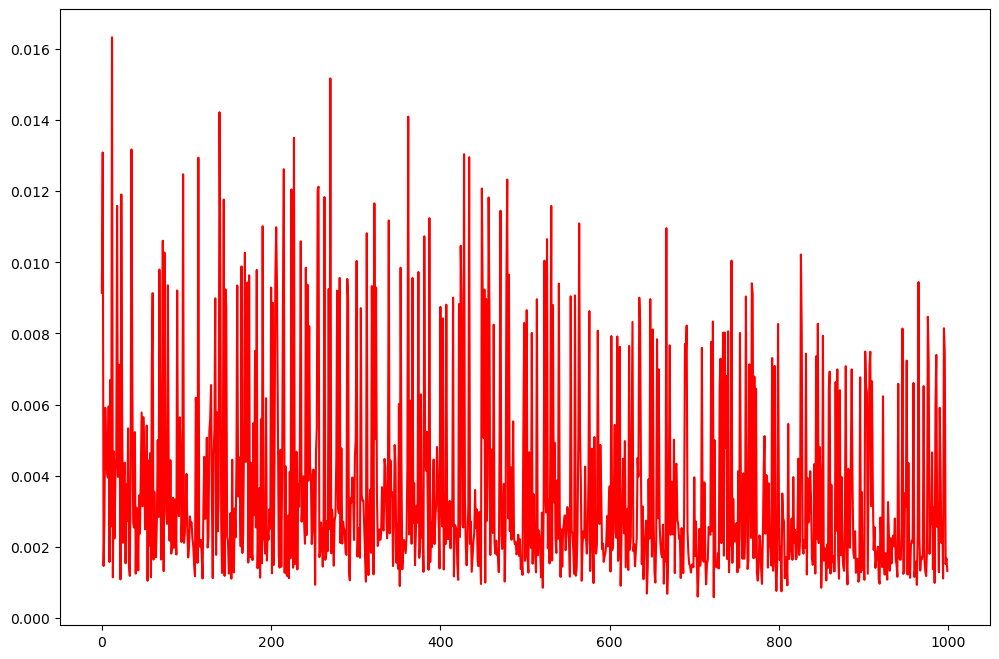

In [275]:
#訓練
# rnn = torch.load('rnn.pkl')

losses = []


optimizer = torch.optim.Adam(rnns[LABEL].parameters(), lr=LR) # optimize all cnn parameters
loss_func = nn.MSELoss()
for step in range(EPOCH):
    for tx, ty in train_loader:
        optimizer.zero_grad() # clear gradients for this training step
        # print(tx.shape)
        # print(tx)
        output,(h_n,c_n) = rnns[LABEL](tx)
        ty=torch.squeeze(ty)
        # print(ty.shape)
        # print(torch.squeeze(output[:,-1,:]).shape)
        loss = loss_func(torch.squeeze(output[:,-1,:]), ty)
        # print(loss)

        loss.backward() # back propagation, compute gradients
        optimizer.step()
    losses.append(loss.item()/BATCH_SIZE)
    print(step, losses[-1])
    if step % 10:
        torch.save(rnns[LABEL], f'rnn_{LABEL}mul+2330.pt')
torch.save(rnns[LABEL], f'rnn_{LABEL}mul+2330.pt')
plt.figure(figsize=(12,8))
plt.plot(np.array(losses), 'r')
plt.show()

In [276]:
test_feature, test_label, df_index= getTestData(df, FEATURES, LABEL, days_before=DAYS_BEFORE, train_end=TRAIN_END)
# flatern each day in train data
test_feature_tensor = torch.Tensor(np.array(test_feature.values.tolist()))
test_label_tensor = torch.Tensor(np.array(test_label.values.tolist()))
# 创建 dataloader
# print(train_feature_tensor)
# print(train_label_tensor)
test_set = TrainSet(test_feature_tensor, test_label_tensor)
# print(train_set.__len__())
train_test_loader = DataLoader(train_set, batch_size=1, shuffle=False)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)

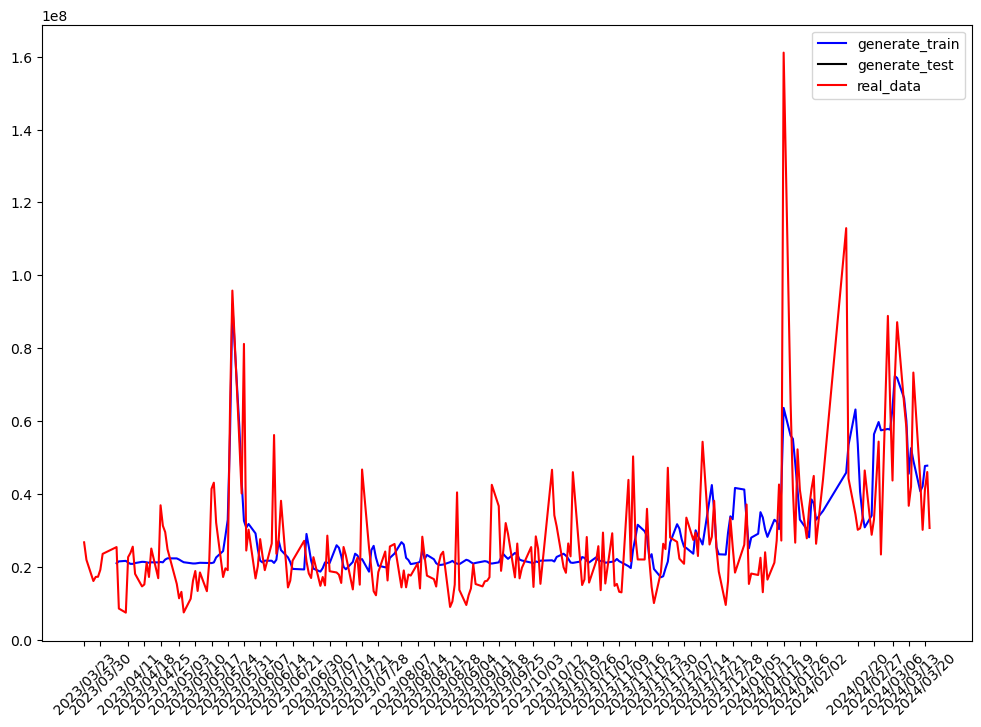

In [277]:
generate_data_train = []
generate_data_test = []
# 测试数据开始的索引
test_start = len(all_series) + TRAIN_END
# 对所有的数据进行相同的归一化
train_mean = all_series.mean()
train_std = all_series.std()
all_series_std = (all_series - train_mean) / train_std
all_series_std = torch.Tensor(all_series_std)
for tx, ty in train_test_loader:
    out, (h_n,c_n) = rnns[LABEL].predict(tx)
#     print(out.detach().flatten()[-1])
    generate_data_train.append(out.detach().flatten()[-1] * train_std + train_mean)
for tx, ty in test_loader:
    out, (h_n,c_n) = rnns[LABEL].predict(tx)
    generate_data_test.append(out.detach().flatten()[-1] * train_std + train_mean)

plt.figure(figsize=(12,8))
plt.plot(df_index[DAYS_BEFORE: TRAIN_END], generate_data_train, 'b', label='generate_train', )
plt.plot(df_index[TRAIN_END:], generate_data_test, 'k', label='generate_test')
plt.plot(df_index, all_series_std.clone().numpy()* train_std + train_mean, 'r', label='real_data')
# 设置 X 轴的刻度
plt.xticks(df_index[::5], pd.to_datetime(df_index[::5]).strftime('%Y/%m/%d'),rotation=45)
# 隐藏 X 轴的次刻度
# plt.minorticks_off()
plt.legend()
plt.show()


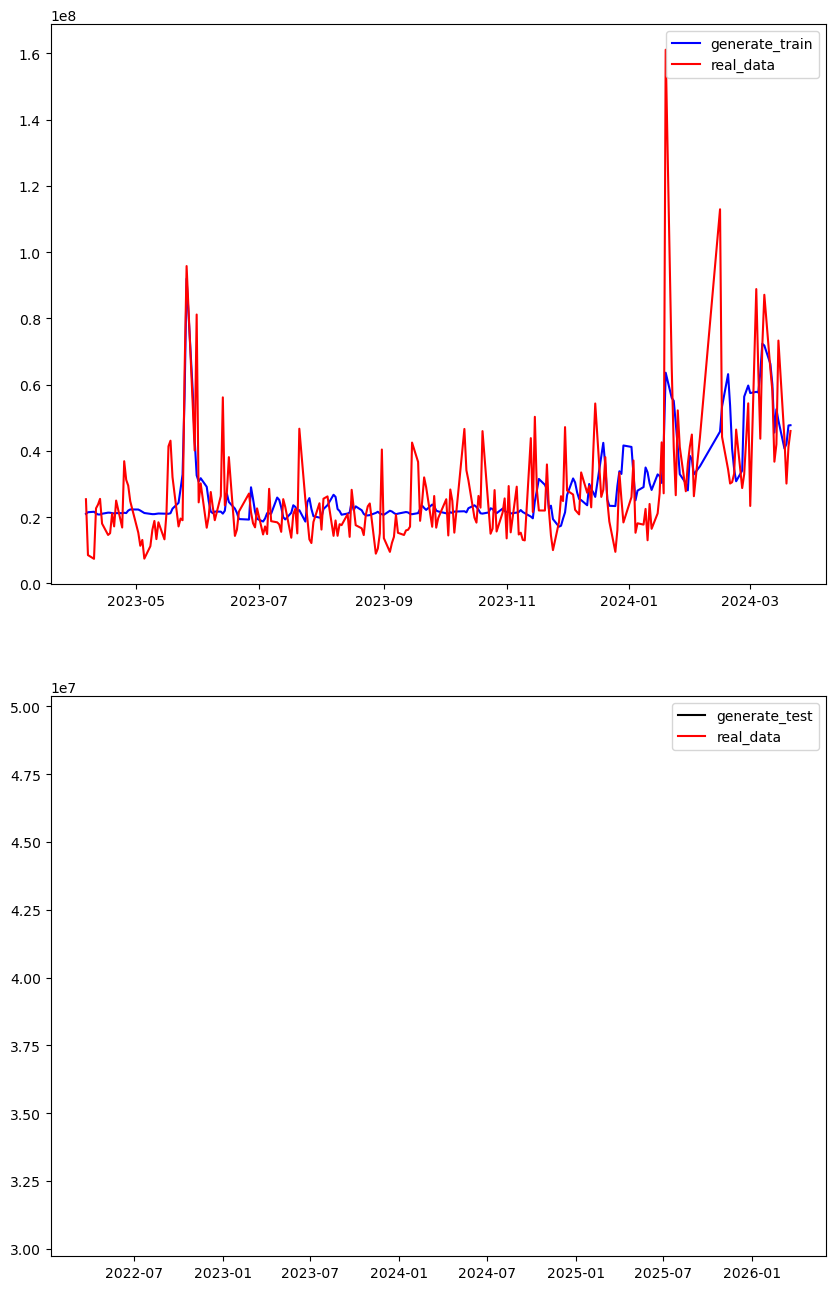

In [278]:
plt.figure(figsize=(10,16))

plt.subplot(2,1,1)
# plt.plot(df_index[100 + DAYS_BEFORE: 130 + DAYS_BEFORE], generate_data_train[100: 130], 'b', label='generate_train')
plt.plot(df_index[7: TRAIN_END], generate_data_train[:], 'b', label='generate_train')
# plt.plot(df_index[100 + DAYS_BEFORE: 130 + DAYS_BEFORE], (all_series.clone().numpy()* train_std + train_mean)[100 + DAYS_BEFORE: 130 + DAYS_BEFORE], 'r', label='real_data')
plt.plot(df_index[7:TRAIN_END], (all_series_std.clone().numpy()* train_std + train_mean)[7: TRAIN_END], 'r', label='real_data')
plt.legend()

plt.subplot(2,1,2)
plt.plot(df_index[TRAIN_END :], generate_data_test[:], 'k', label='generate_test')
plt.plot(df_index[TRAIN_END:], (all_series_std.clone().numpy()* train_std + train_mean)[TRAIN_END :], 'r', label='real_data')
plt.legend()

plt.show()

# FINAL

In [282]:
ansdf=df.copy()
ansdf.tail()

,Open,High,Low,Close,Adj Close,Volume,Volume_2330
2024-03-18,153.00,154.50,153.00,154.40,154.40,17937768,43589856
2024-03-19,153.40,154.55,153.00,154.05,154.05,8569789,30152375
2024-03-20,154.20,155.30,153.00,153.20,153.20,10080404,41280325
2024-03-21,155.55,157.70,155.55,157.40,157.40,19960806,46026103
2024-03-22,157.50,158.25,156.50,157.20,157.20,7137094,30660820


In [283]:
#預測五天
for p in range(5):
    newday=[]
    for (i,lab) in enumerate(FEATURES):
        
#         print(i, lab)
        all_series = np.array(ansdf[lab].tolist())
        train_mean = all_series.mean()
        train_std = all_series.std()
        all_series_std = (all_series - train_mean) / train_std
        all_series_std = torch.Tensor(all_series_std)
        
        ans_f = torch.tensor(ansdf[-242:].values)
#         print(ans_f.dim())
        #ans_f = ans_f.unsqueeze(0)
        ans_f = ans_f.float()
        
        out1, (h_n,c_n) = rnns[lab].predict(ans_f)
        
        tmp=round(out1.detach().flatten()[-1].item()* train_std + train_mean,3)
        if i>=5:
            tmp=int(round(out1.detach().flatten()[-1].item()* train_std + train_mean))
        newday.append(tmp)
        print(newday)
    
    
    ansdf.loc[len(ansdf)]=newday
ansdf.tail()   

[133.64]
[133.64, 139.441]
[133.64, 139.441, 134.953]
[133.64, 139.441, 134.953, 144.501]
[133.64, 139.441, 134.953, 144.501, 148.267]
[133.64, 139.441, 134.953, 144.501, 148.267, 10330646]
[133.64, 139.441, 134.953, 144.501, 148.267, 10330646, 107663202]
[134.233]
[134.233, 138.866]
[134.233, 138.866, 134.881]
[134.233, 138.866, 134.881, 144.272]
[134.233, 138.866, 134.881, 144.272, 148.024]
[134.233, 138.866, 134.881, 144.272, 148.024, 10395174]
[134.233, 138.866, 134.881, 144.272, 148.024, 10395174, 110621609]
[134.495]
[134.495, 138.506]
[134.495, 138.506, 134.794]
[134.495, 138.506, 134.794, 143.983]
[134.495, 138.506, 134.794, 143.983, 147.812]
[134.495, 138.506, 134.794, 143.983, 147.812, 10442694]
[134.495, 138.506, 134.794, 143.983, 147.812, 10442694, 113842185]
[135.027]
[135.027, 138.277]
[135.027, 138.277, 134.743]
[135.027, 138.277, 134.743, 143.725]
[135.027, 138.277, 134.743, 143.725, 147.654]
[135.027, 138.277, 134.743, 143.725, 147.654, 10468224]
[135.027, 138.277, 134

,Open,High,Low,Close,Adj Close,Volume,Volume_2330
243,133.640,139.441,134.953,144.501,148.267,10330646.0,107663202.0
244,134.233,138.866,134.881,144.272,148.024,10395174.0,110621609.0
245,134.495,138.506,134.794,143.983,147.812,10442694.0,113842185.0
246,135.027,138.277,134.743,143.725,147.654,10468224.0,117226818.0
247,135.376,138.125,134.721,143.502,147.549,10481136.0,120728600.0


In [281]:
#預測五天DATALOADER
for p in range(5):
    newday=[]
    for (i,lab) in enumerate(FEATURES):
        
#         print(i, lab)
        #dataLOADER
        test_feature, test_label, df_index= getTestData(ansdf, FEATURES, lab, days_before=DAYS_BEFORE, train_end=-1)
        # flatern each day in train data
        test_feature_tensor = torch.Tensor(np.array(test_feature.values.tolist()))
        test_label_tensor = torch.Tensor(np.array(test_label.values.tolist()))
        # 创建 dataloader
        test_set = TrainSet(test_feature_tensor, test_label_tensor)
        test_loader = DataLoader(test_set, batch_size=1, shuffle=False)
        
        # 对所有的数据进行相同的归一化
        all_series = np.array(ansdf[lab].tolist())
        train_mean = all_series.mean()
        train_std = all_series.std()
        all_series_std = (all_series - train_mean) / train_std
        all_series_std = torch.Tensor(all_series_std)

        for tx, ty in test_loader:
            out, (h_n,c_n) = rnns[LABEL].predict(tx)
            
            tmp=round(out.detach().flatten()[-1].item()* train_std + train_mean,3)
            if i>=5:
                tmp=int(round(out1.detach().flatten()[-1].item()* train_std + train_mean))
            newday.append(tmp)
            print(newday)
    
    
    ansdf.loc[len(ansdf)]=newday
ansdf.tail()   

[151.527]
[151.527, 152.52]
[151.527, 152.52, 150.966]
[151.527, 152.52, 150.966, 152.163]
[151.527, 152.52, 150.966, 152.163, 152.247]
[151.527, 152.52, 150.966, 152.163, 152.247, 21332708]
[151.527, 152.52, 150.966, 152.163, 152.247, 21332708, 58533572]
[155.961]
[155.961, 157.045]
[155.961, 157.045, 155.389]
[155.961, 157.045, 155.389, 156.7]
[155.961, 157.045, 155.389, 156.7, 157.389]
[155.961, 157.045, 155.389, 156.7, 157.389, 21412394]
[155.961, 157.045, 155.389, 156.7, 157.389, 21412394, 58747125]
[156.824]
[156.824, 157.926]
[156.824, 157.926, 156.25]
[156.824, 157.926, 156.25, 157.583]
[156.824, 157.926, 156.25, 157.583, 158.391]
[156.824, 157.926, 156.25, 157.583, 158.391, 21492011]
[156.824, 157.926, 156.25, 157.583, 158.391, 21492011, 58960489]
[135.985]
[135.985, 136.659]
[135.985, 136.659, 135.463]
[135.985, 136.659, 135.463, 136.259]
[135.985, 136.659, 135.463, 136.259, 134.221]
[135.985, 136.659, 135.463, 136.259, 134.221, 21571557]
[135.985, 136.659, 135.463, 136.259, 

,Open,High,Low,Close,Adj Close,Volume,Volume_2330
248,151.527,152.520,150.966,152.163,152.247,21332708.0,58533572.0
249,155.961,157.045,155.389,156.700,157.389,21412394.0,58747125.0
250,156.824,157.926,156.250,157.583,158.391,21492011.0,58960489.0
251,135.985,136.659,135.463,136.259,134.221,21571557.0,59173667.0
252,134.755,135.404,134.236,135.000,132.794,21651034.0,59386660.0
